In [1]:
# %%
"""

Pack the scRNA-seq data using scanpy, prep for scran normalisation

"""

import logging, matplotlib, os, sys
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from anndata import AnnData
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from scipy.sparse import csr_matrix
from rpy2.robjects.packages import importr
plt.rcParams['figure.figsize'] = (8,8)
sc.settings.verbosity = 3
sc.set_figure_params(dpi=200, dpi_save=200)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 10
sc.settings.autoshow = False

In [2]:
# %%
#file_path = '~/apps/scTE/Data/GSE149372_GSM5068636-GSM5068641_scRNA.MetaData.105.csv'
og_path = os.getcwd()
os.chdir('/users/nsuthy/data/scTE')
adata = sc.read_h5ad('PAH_2022_disease_scTE.h5ad')
os.chdir(og_path)
adata

AnnData object with n_obs × n_vars = 6073 × 96
    obs: 'sample', 'n_genes', 'n_counts', 'log_counts', 'mt_frac', 'size_factors', 'louvain_1.0', 'louvain_0.6', 'louvain_0.4', 'louvain_0.2', 'louvain_1.4', 'kmeans5', 'kmeans10', 'kmeans15', 'leiden_1.0', 'leiden_0.8', 'leiden_0.5', 'leiden_0.2', 'leiden_1.4'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_kmeans5', 'hvg', 'kmeans10_colors', 'kmeans15_colors', 'kmeans5_colors', 'leiden', 'leiden_0.2_colors', 'leiden_0.5_colors', 'leiden_1.0_colors', 'leiden_1.4_colors', 'log1p', 'louvain', 'louvain_0.2_colors', 'louvain_0.4_colors', 'louvain_0.6_colors', 'louvain_1.0_colors', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# Preproccesing 

In [3]:
adata.X

array([[1.03032503, 0.        , 6.32724492, ..., 7.77620479, 5.85185892,
        6.09646895],
       [0.        , 2.33805147, 6.2602416 , ..., 7.75122031, 6.42175794,
        6.65185726],
       [0.        , 0.87424546, 6.07966901, ..., 7.80101123, 6.25519043,
        6.29464683],
       ...,
       [0.        , 2.41024806, 6.12607248, ..., 7.49475216, 5.63134024,
        6.03445474],
       [1.70684342, 0.49743955, 6.14351641, ..., 7.78503899, 5.7039505 ,
        6.30778768],
       [0.6308266 , 2.52004229, 6.16857774, ..., 7.96165975, 6.18501234,
        6.08409683]])

In [4]:
sc.pp.filter_cells(adata, min_genes = 20) #get rid of cells that express <20 genes
sc.pp.filter_genes(adata, min_cells = 10) #get rid of genes that are expressed in <10 cells
adata.obs

sample  n_genes  n_counts  log_counts   mt_frac  \
AAACAGGGTCTATATT      LAD_S1       85   93417.0   11.444829  0.067964   
AAACATTTCCCGGATT      LAD_S1       77   55027.0   10.915579  0.091464   
AAACCGGGTAGGTACC      LAD_S1       80   60777.0   11.014967  0.047502   
AAACCGTTCGTCCAGG      LAD_S1       83  121150.0   11.704785  0.054445   
AAACCTCATGAAGTTG      LAD_S1       76   60897.0   11.016939  0.066243   
...                      ...      ...       ...         ...       ...   
TTGTGTTTCCCGAAAG-4  RL_A6_S1       84  198436.0   12.198222  0.065669   
TTGTTAGCAAATTCGA-4  RL_A6_S1       82  171962.0   12.055029  0.057088   
TTGTTCAGTGTGCTAC-1  RL_A6_S1       84  164653.0   12.011596  0.047797   
TTGTTGTGTGTCAAGA-2  RL_A6_S1       83  129999.0   11.775282  0.087762   
TTGTTTCCATACAACT-3  RL_A6_S1       82  105157.0   11.563210  0.060082   

                    size_factors louvain_1.0 louvain_0.6 louvain_0.4  \
AAACAGGGTCTATATT        1.109892           1           0           0   
AAACATTTCCCGGATT        0.534129           7           3           1   
AAACCGGGTAGGTACC        0.715786           3           0           0   
AAACCGTTCGTCCAGG        1.399002           5           0           0   
AAACCTCATGAAGTTG        0.667870           2           1           0   
...                          ...         ...         ...         ...   
TTGTGTTTCCCGAAAG-4      2.207777           0           0           0   
TTGTTAGCAAATTCGA-4      1.945211           3           0           0   
TTGTTCAGTGTGCTAC-1      2.071675           0           2           0   
TTGTTGTGTGTCAAGA-2      1.551578           0           2           0   
TTGTTTCCATACAACT-3      1.137445           0           2           0   

                   louvain_0.2 louvain_1.4 kmeans5 kmeans10 kmeans15  \
AAACAGGGTCTATATT             0          14       4        5        1   
AAACATTTCCCGGATT             0          12       0        8       12   
AAACCGGGTAGGTACC             0          14       4        7        4   
AAACCGTTCGTCCAGG             0          13       3        3        9   
AAACCTCATGAAGTTG             0           6       0        4       13   
...                        ...         ...     ...      ...      ...   
TTGTGTTTCCCGAAAG-4           0           7       4        3       14   
TTGTTAGCAAATTCGA-4           0           8       4        5        2   
TTGTTCAGTGTGCTAC-1           0           0       3        5       14   
TTGTTGTGTGTCAAGA-2           0           0       3        0        8   
TTGTTTCCATACAACT-3           0           1       4        0        1   

                   leiden_1.0 leiden_0.8 leiden_0.5 leiden_0.2 leiden_1.4  
AAACAGGGTCTATATT           10          7          1          0         20  
AAACATTTCCCGGATT            7          6          2          0          6  
AAACCGGGTAGGTACC            6          7          1          0         16  
AAACCGTTCGTCCAGG           15          3          1          0         25  
AAACCTCATGAAGTTG           11          0          0          0         24  
...                       ...        ...        ...        ...        ...  
TTGTGTTTCCCGAAAG-4         10          3          1          0          9  
TTGTTAGCAAATTCGA-4          7          6          1          0          8  
TTGTTCAGTGTGCTAC-1          0          2          1          0          1  
TTGTTGTGTGTCAAGA-2          0          2          1          0          2  
TTGTTTCCATACAACT-3          0          2          1          0          2  

[6073 rows x 19 columns]

In [5]:
adata.var['L1'] = adata.var_names.str.startswith('L1') #annotate the group of mitochondrial genes as 'mt'

In [6]:
adata.var

n_cells  highly_variable     means  dispersions  dispersions_norm  \
L1M         1986             True  1.174275     2.331346          0.321941   
L1M1        2993             True  1.581349     2.670174         -0.073563   
L1M2        6073             True  6.310781     3.310135         -0.413382   
L1M2a        306             True  0.207994     2.558434          0.135019   
L1M2c       3639             True  1.948301     2.692222         -1.077013   
...          ...              ...       ...          ...               ...   
L1_Mus1     6073             True  6.737751     3.160596          1.000000   
L1_Mus2     6073             True  6.341530     3.239223         -0.727031   
L1_Mus3     6073             True  7.908643     4.332655          0.707107   
L1_Mus4     6073             True  5.955773     3.065658         -1.119763   
L1_Rod      6073             True  6.313902     3.661427          1.140413   

           L1  
L1M      True  
L1M1     True  
L1M2     True  
L1M2a    True  
L1M2c    True  
...       ...  
L1_Mus1  True  
L1_Mus2  True  
L1_Mus3  True  
L1_Mus4  True  
L1_Rod   True  

[96 rows x 6 columns]

In [7]:
adata.var[adata.var.L1 == True]
#none of these cells appear to be mitochondrial genes

n_cells  highly_variable     means  dispersions  dispersions_norm  \
L1M         1986             True  1.174275     2.331346          0.321941   
L1M1        2993             True  1.581349     2.670174         -0.073563   
L1M2        6073             True  6.310781     3.310135         -0.413382   
L1M2a        306             True  0.207994     2.558434          0.135019   
L1M2c       3639             True  1.948301     2.692222         -1.077013   
...          ...              ...       ...          ...               ...   
L1_Mus1     6073             True  6.737751     3.160596          1.000000   
L1_Mus2     6073             True  6.341530     3.239223         -0.727031   
L1_Mus3     6073             True  7.908643     4.332655          0.707107   
L1_Mus4     6073             True  5.955773     3.065658         -1.119763   
L1_Rod      6073             True  6.313902     3.661427          1.140413   

           L1  
L1M      True  
L1M1     True  
L1M2     True  
L1M2a    True  
L1M2c    True  
...       ...  
L1_Mus1  True  
L1_Mus2  True  
L1_Mus3  True  
L1_Mus4  True  
L1_Rod   True  

[96 rows x 6 columns]

In [8]:
adata.obs

sample  n_genes  n_counts  log_counts   mt_frac  \
AAACAGGGTCTATATT      LAD_S1       85   93417.0   11.444829  0.067964   
AAACATTTCCCGGATT      LAD_S1       77   55027.0   10.915579  0.091464   
AAACCGGGTAGGTACC      LAD_S1       80   60777.0   11.014967  0.047502   
AAACCGTTCGTCCAGG      LAD_S1       83  121150.0   11.704785  0.054445   
AAACCTCATGAAGTTG      LAD_S1       76   60897.0   11.016939  0.066243   
...                      ...      ...       ...         ...       ...   
TTGTGTTTCCCGAAAG-4  RL_A6_S1       84  198436.0   12.198222  0.065669   
TTGTTAGCAAATTCGA-4  RL_A6_S1       82  171962.0   12.055029  0.057088   
TTGTTCAGTGTGCTAC-1  RL_A6_S1       84  164653.0   12.011596  0.047797   
TTGTTGTGTGTCAAGA-2  RL_A6_S1       83  129999.0   11.775282  0.087762   
TTGTTTCCATACAACT-3  RL_A6_S1       82  105157.0   11.563210  0.060082   

                    size_factors louvain_1.0 louvain_0.6 louvain_0.4  \
AAACAGGGTCTATATT        1.109892           1           0           0   
AAACATTTCCCGGATT        0.534129           7           3           1   
AAACCGGGTAGGTACC        0.715786           3           0           0   
AAACCGTTCGTCCAGG        1.399002           5           0           0   
AAACCTCATGAAGTTG        0.667870           2           1           0   
...                          ...         ...         ...         ...   
TTGTGTTTCCCGAAAG-4      2.207777           0           0           0   
TTGTTAGCAAATTCGA-4      1.945211           3           0           0   
TTGTTCAGTGTGCTAC-1      2.071675           0           2           0   
TTGTTGTGTGTCAAGA-2      1.551578           0           2           0   
TTGTTTCCATACAACT-3      1.137445           0           2           0   

                   louvain_0.2 louvain_1.4 kmeans5 kmeans10 kmeans15  \
AAACAGGGTCTATATT             0          14       4        5        1   
AAACATTTCCCGGATT             0          12       0        8       12   
AAACCGGGTAGGTACC             0          14       4        7        4   
AAACCGTTCGTCCAGG             0          13       3        3        9   
AAACCTCATGAAGTTG             0           6       0        4       13   
...                        ...         ...     ...      ...      ...   
TTGTGTTTCCCGAAAG-4           0           7       4        3       14   
TTGTTAGCAAATTCGA-4           0           8       4        5        2   
TTGTTCAGTGTGCTAC-1           0           0       3        5       14   
TTGTTGTGTGTCAAGA-2           0           0       3        0        8   
TTGTTTCCATACAACT-3           0           1       4        0        1   

                   leiden_1.0 leiden_0.8 leiden_0.5 leiden_0.2 leiden_1.4  
AAACAGGGTCTATATT           10          7          1          0         20  
AAACATTTCCCGGATT            7          6          2          0          6  
AAACCGGGTAGGTACC            6          7          1          0         16  
AAACCGTTCGTCCAGG           15          3          1          0         25  
AAACCTCATGAAGTTG           11          0          0          0         24  
...                       ...        ...        ...        ...        ...  
TTGTGTTTCCCGAAAG-4         10          3          1          0          9  
TTGTTAGCAAATTCGA-4          7          6          1          0          8  
TTGTTCAGTGTGCTAC-1          0          2          1          0          1  
TTGTTGTGTGTCAAGA-2          0          2          1          0          2  
TTGTTTCCATACAACT-3          0          2          1          0          2  

[6073 rows x 19 columns]

[<Axes: ylabel='n_genes'>, <Axes: ylabel='n_counts'>]

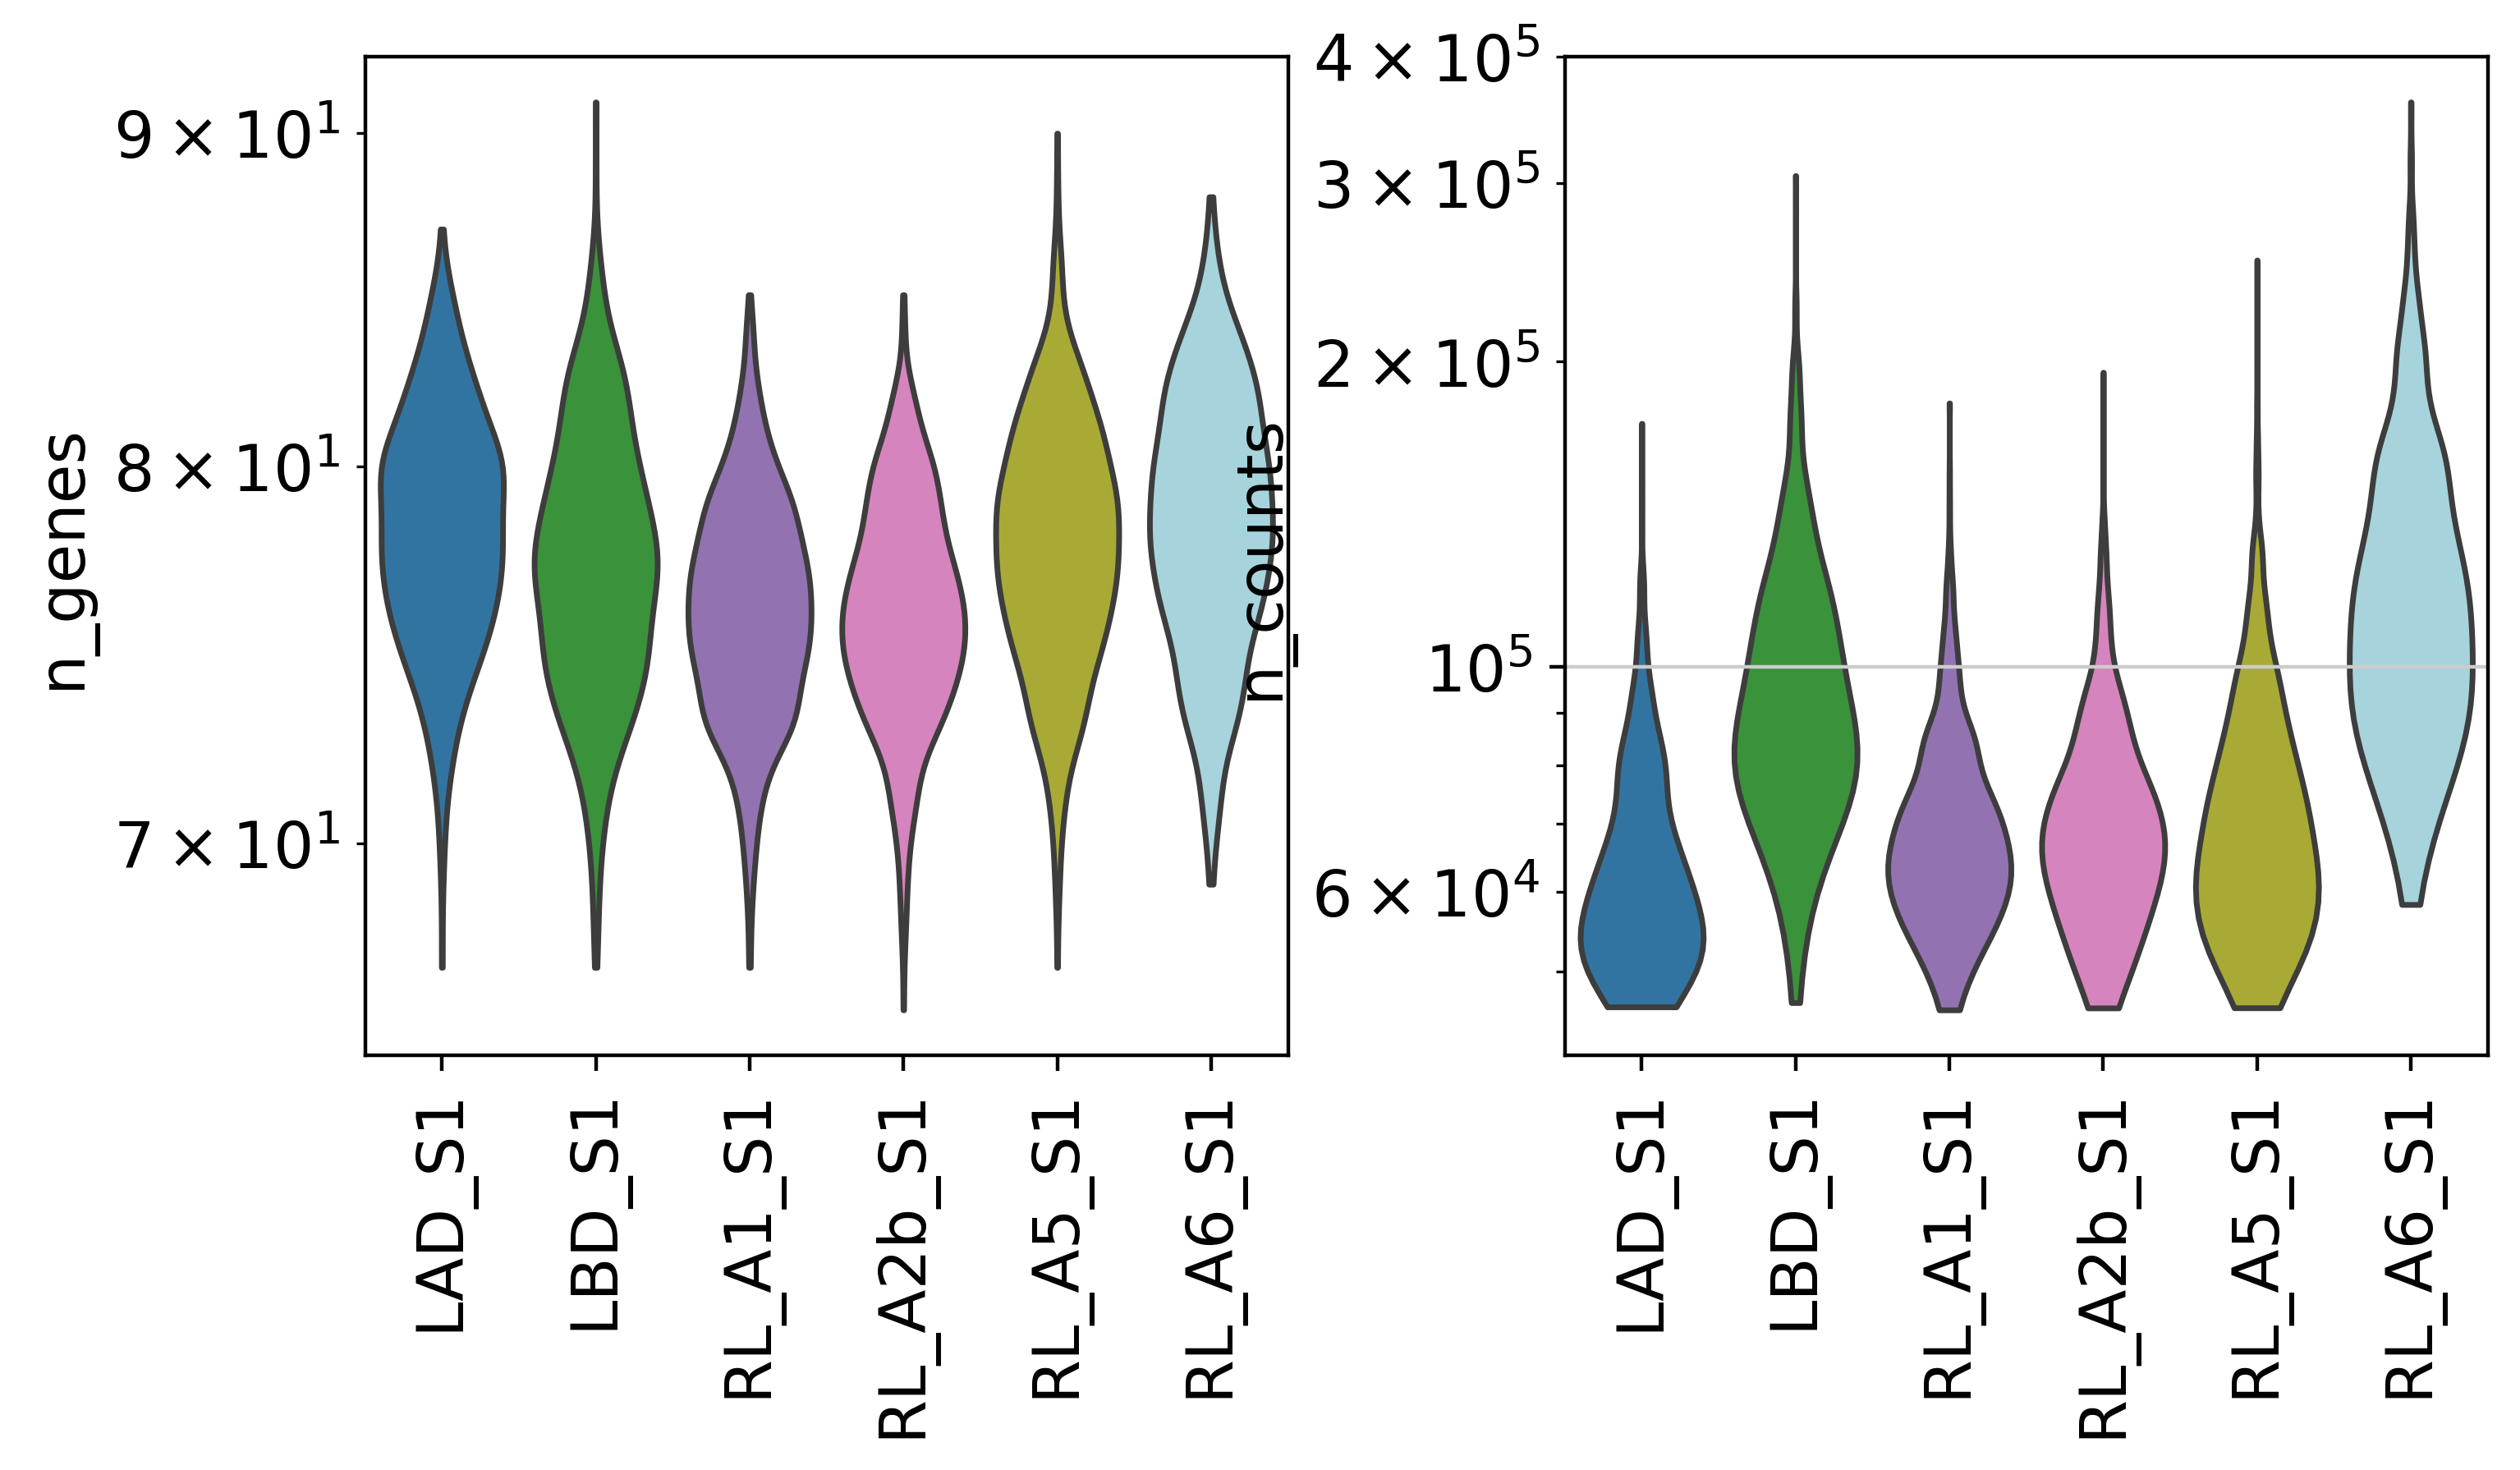

In [9]:
sc.pl.violin(adata, ['n_genes','n_counts'], groupby='sample', size=1, log=True, cut=0,stripplot=False,rotation=90)

<Axes: xlabel='size_factors', ylabel='n_genes'>

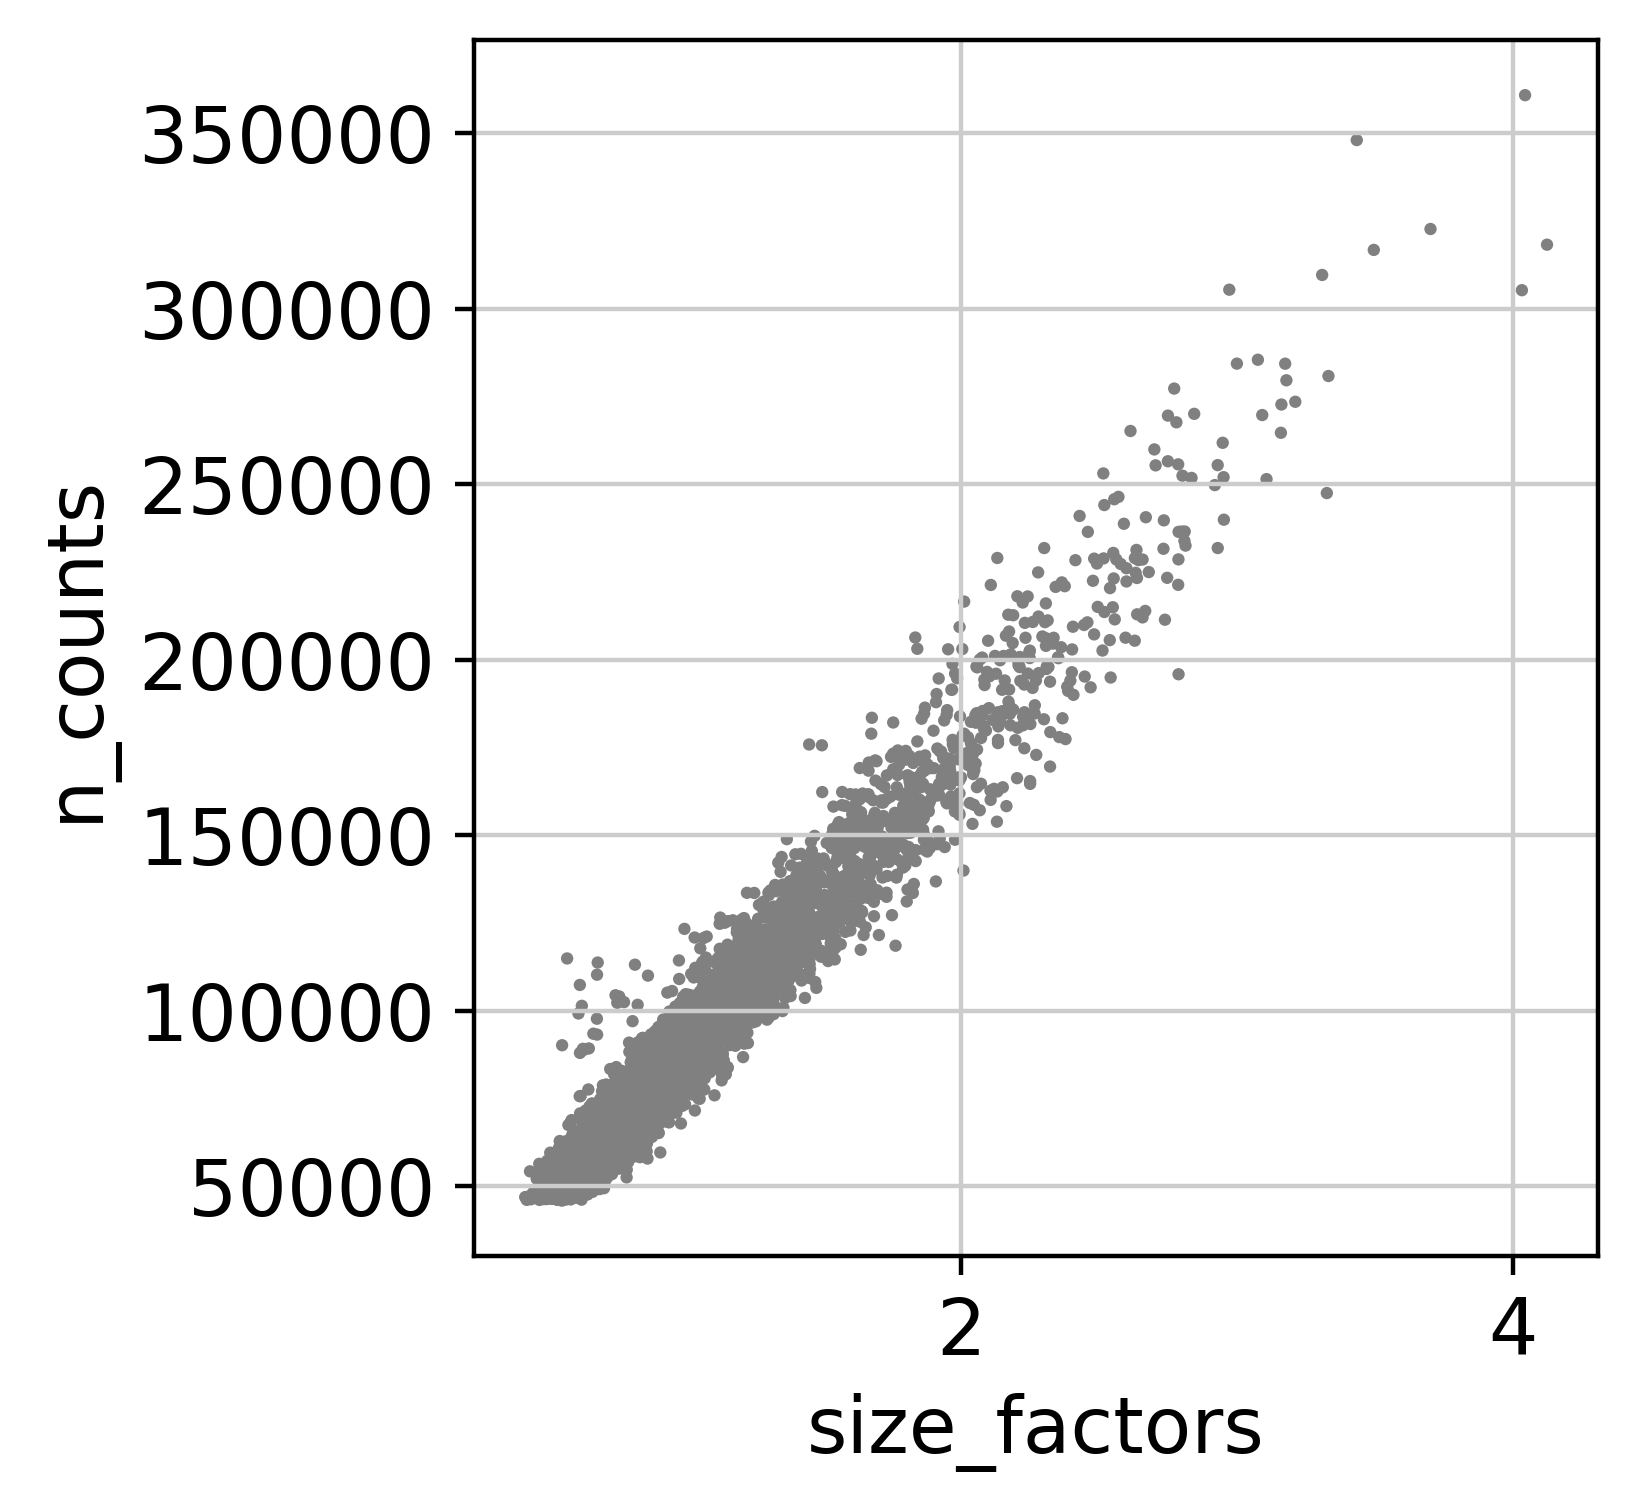

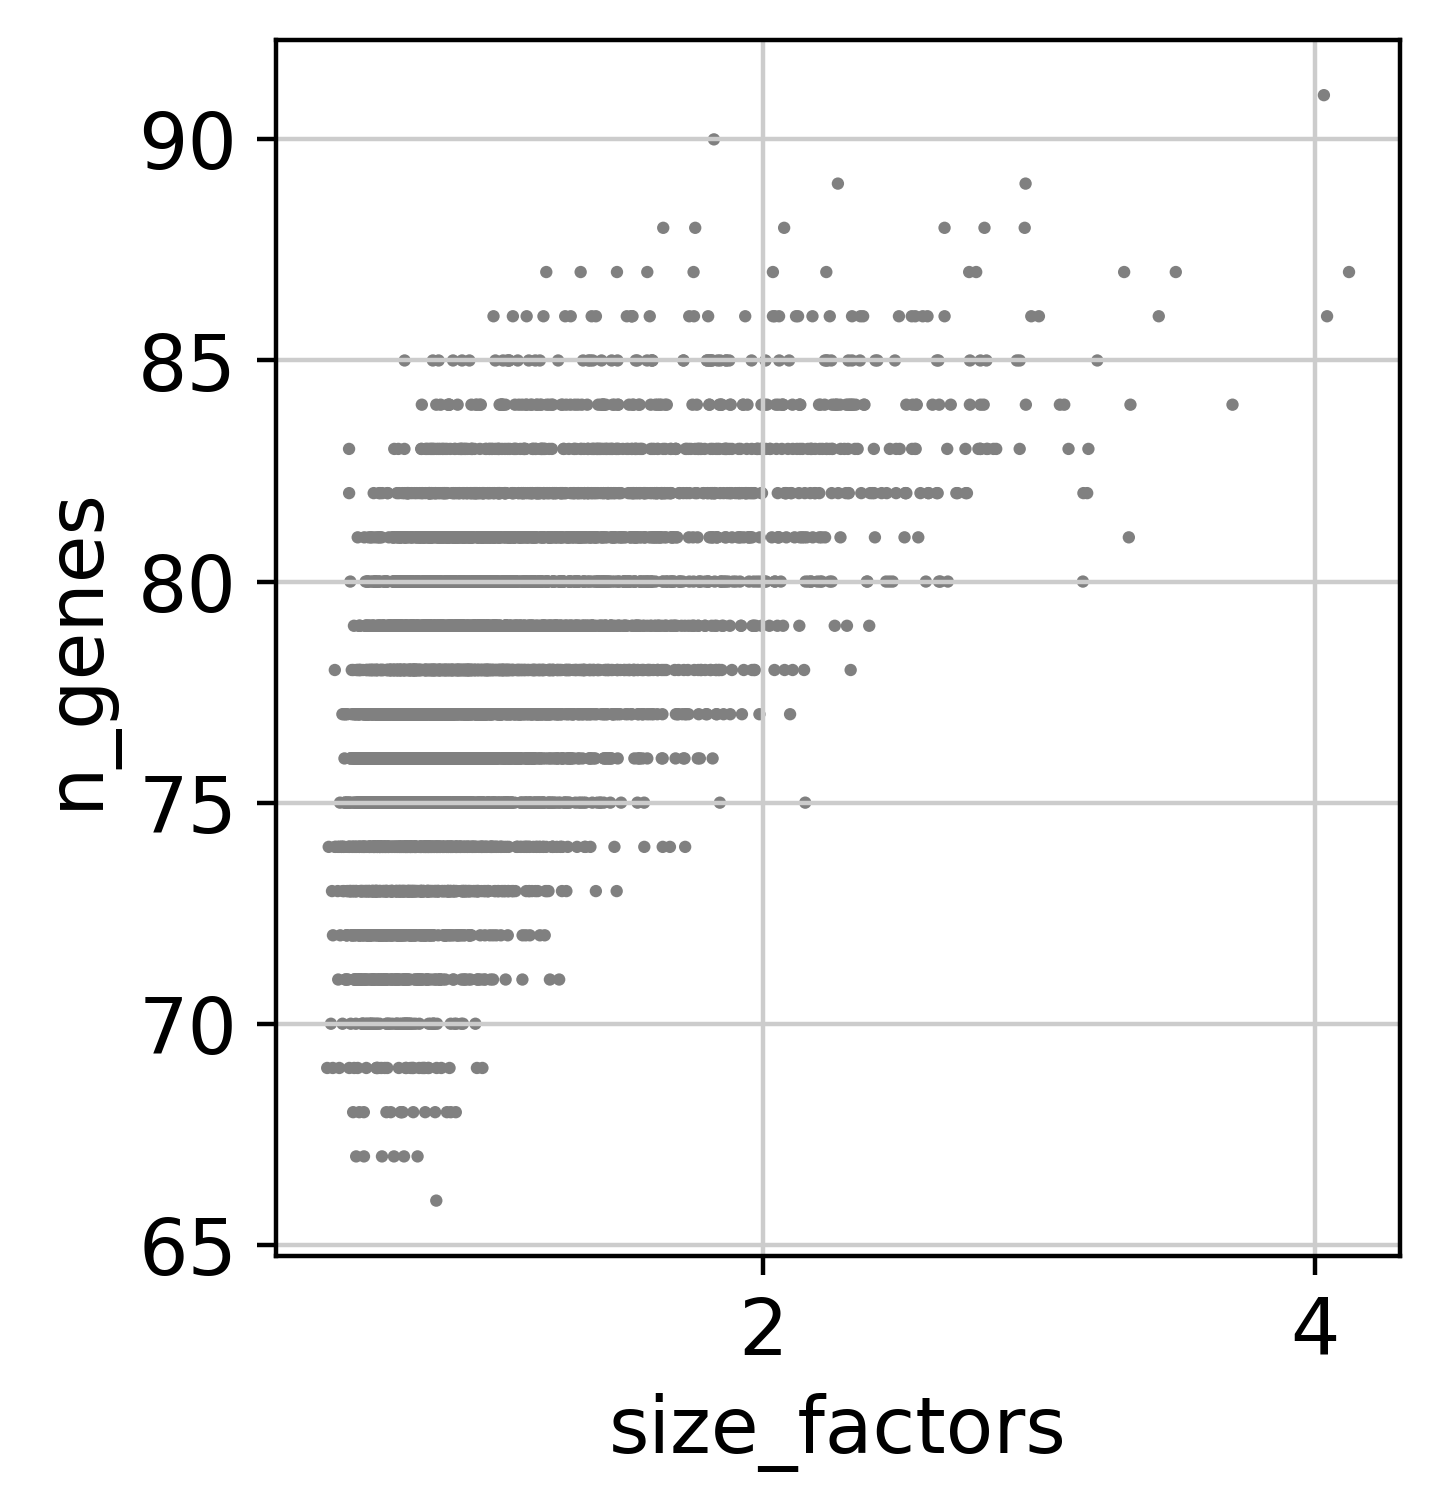

In [10]:
size_factors = adata.obs['size_factors']
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

/tmp/ipykernel_541102/965560014.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(size_factors, bins=50, kde=False)


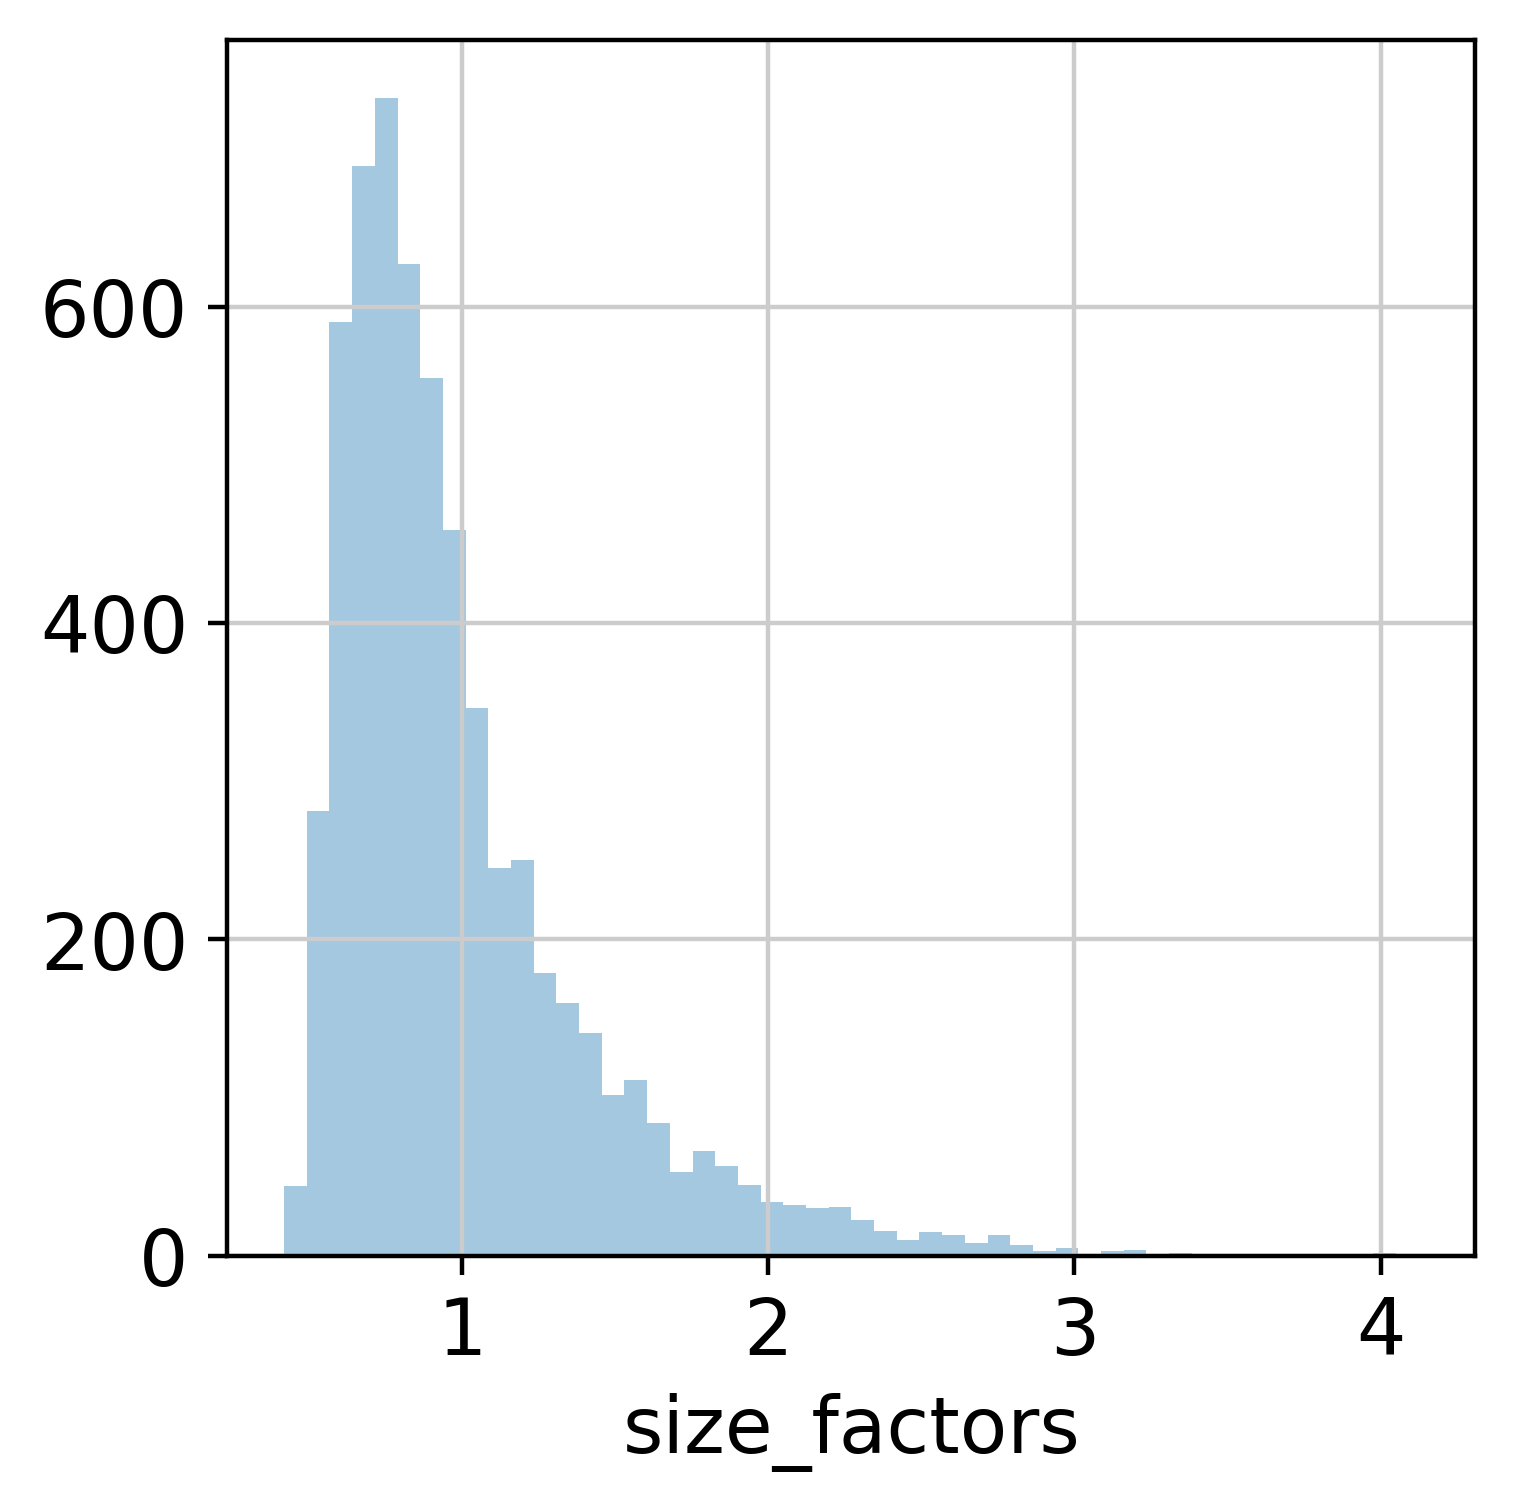

In [11]:
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [12]:
adata.X[10,:].sum()
# total number of UMI counts for cell 5 is 321.1181209146651
# "UMIs are short, random sequences of nucleotides added to each RNA molecule during the library preparation step of scRNA-seq"

320.85169420854834

In [13]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e3) #this method has been deprecated and replaced by normalize_total
sc.pp.normalize_total(adata)
# "normalizing" each cell to make sure they all have the same number of counts for sampling 

normalizing counts per cell
    finished (0:00:00)


In [14]:
sc.pp.log1p(adata)
#change teh UMI counts to log counts

# Clustering

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


<Axes: xlabel='mean expressions of genes', ylabel='dispersions of genes (not normalized)'>

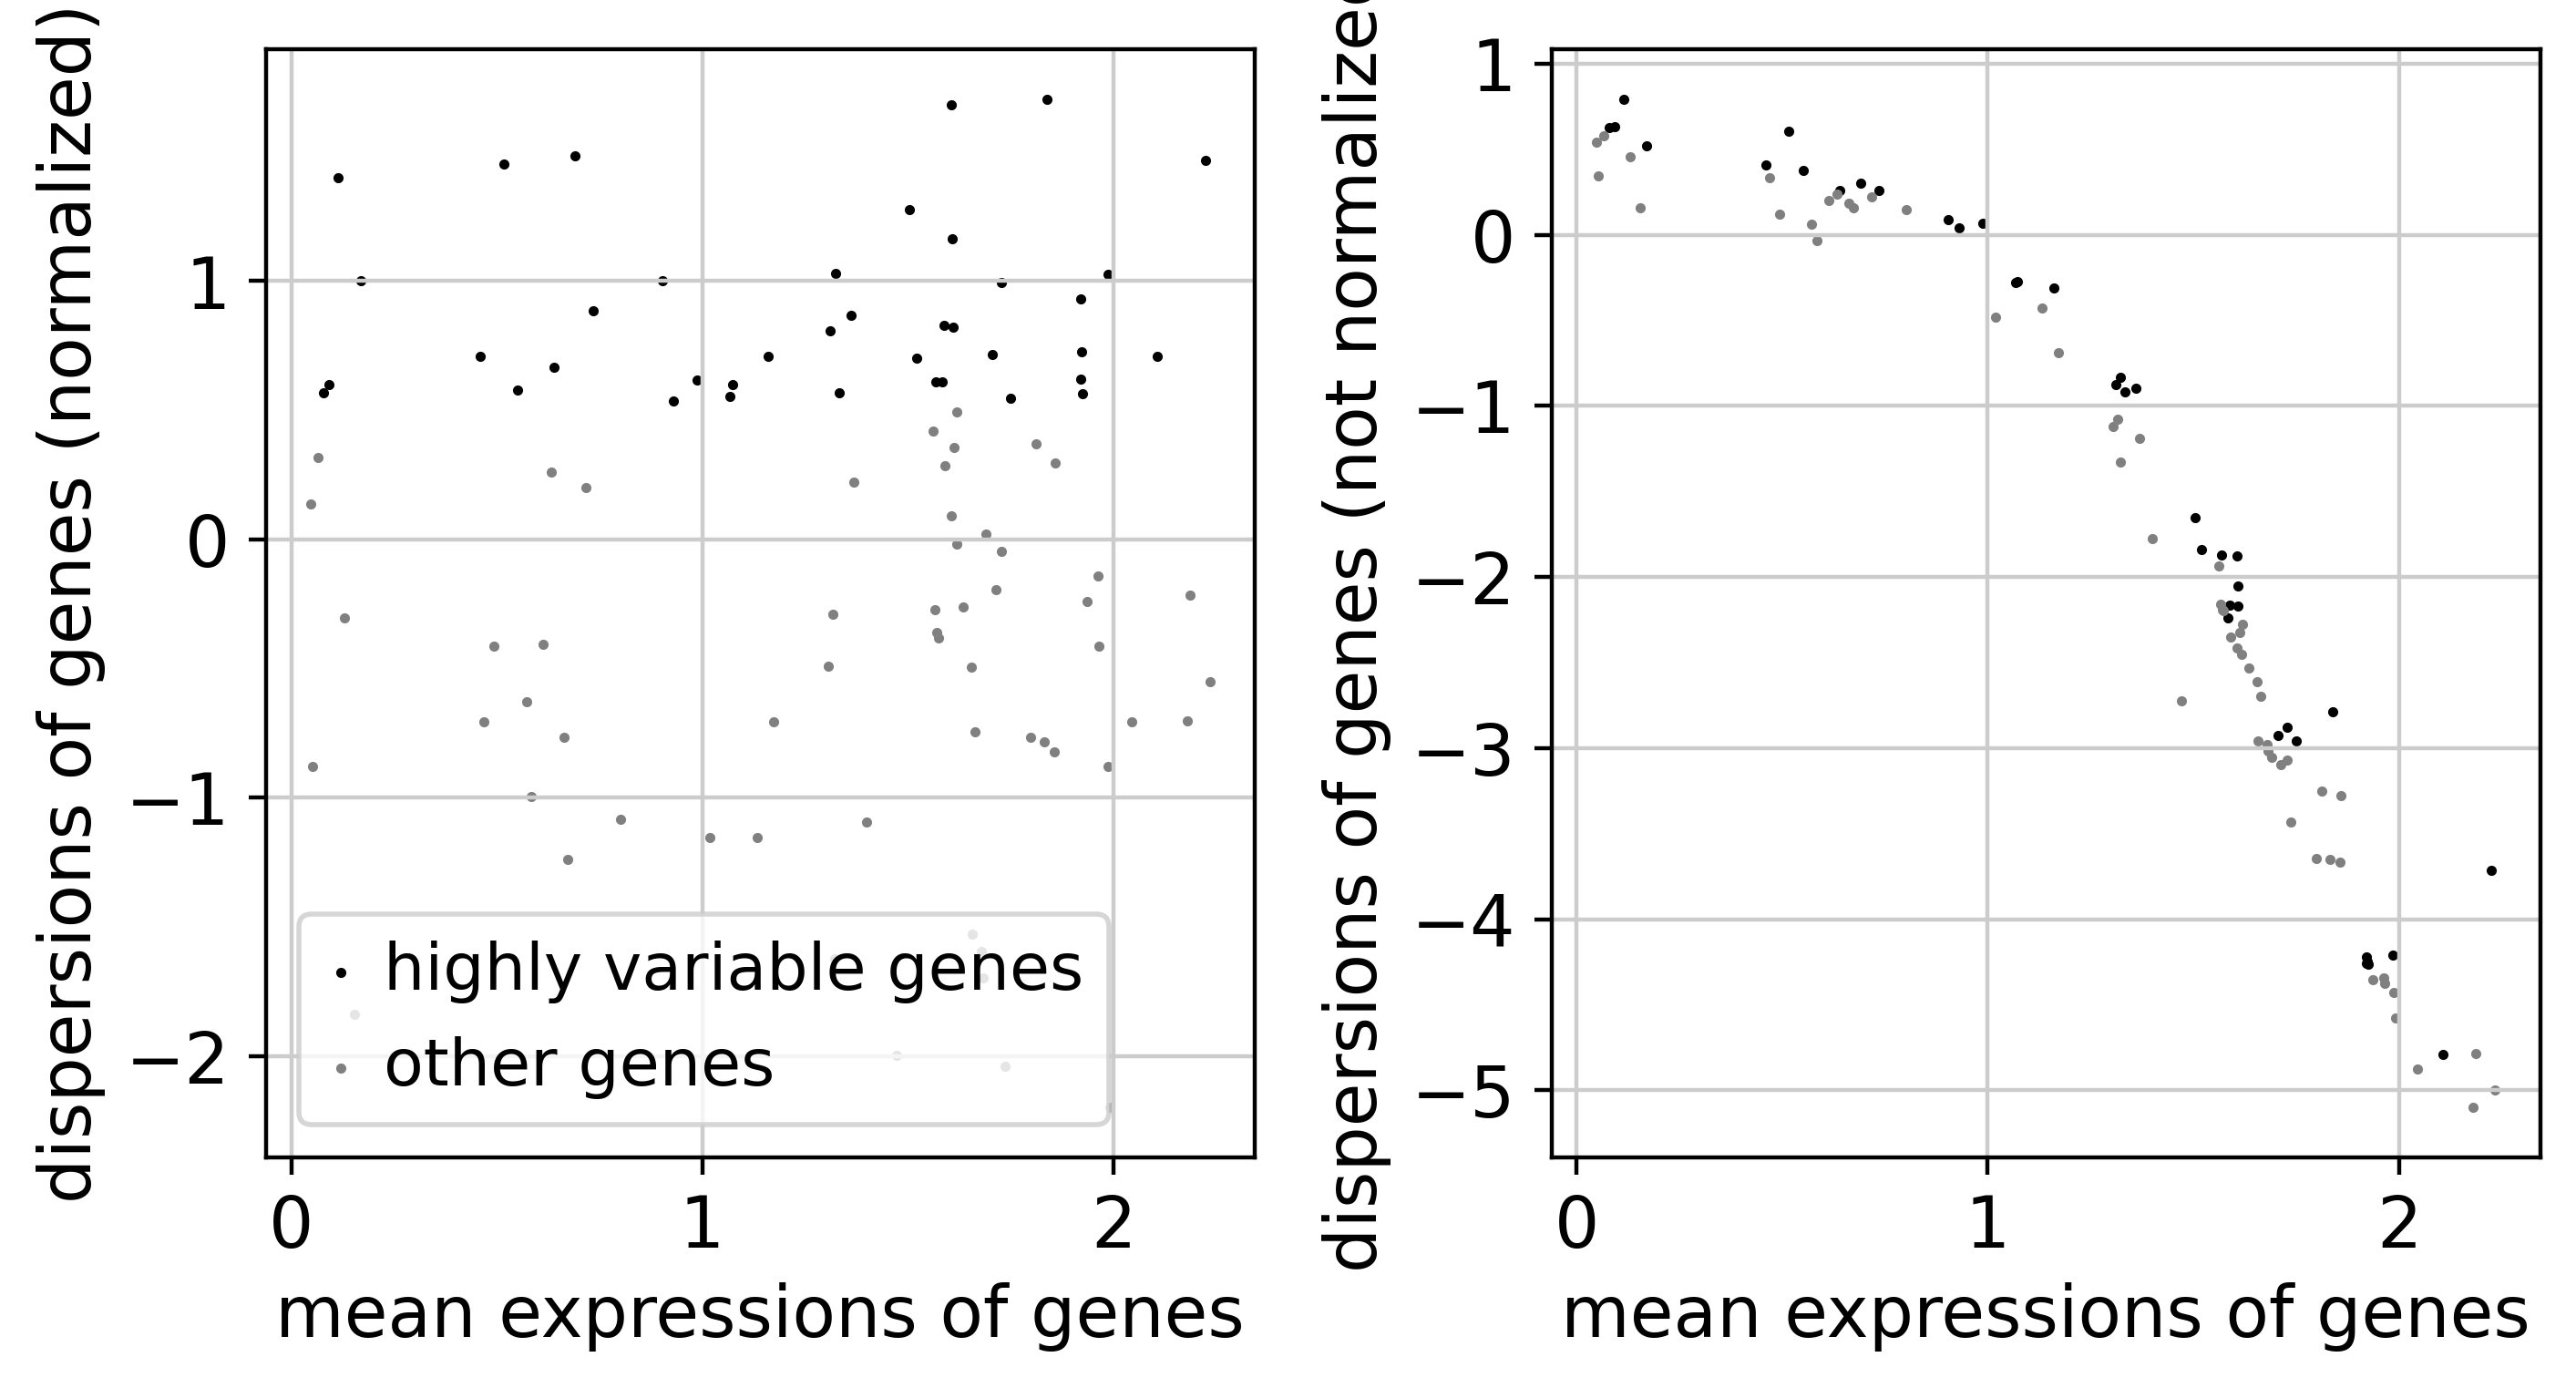

In [15]:
sc.pp.highly_variable_genes(adata, min_disp=0.5, min_mean=0.0125, max_mean=3)
sc.pl.highly_variable_genes(adata)

In [16]:
adata.raw = adata #save raw data before filtering adata further
adata.var

n_cells  highly_variable     means  dispersions  dispersions_norm  \
L1M         1986             True  0.460554     0.406604          0.707107   
L1M1        2993             True  0.640306     0.259169          0.665589   
L1M2        6073            False  1.987082    -4.429053         -0.880432   
L1M2a        306            False  0.065701     0.579189          0.318566   
L1M2c       3639            False  0.801178     0.148503         -1.084807   
...          ...              ...       ...          ...               ...   
L1_Mus1     6073            False  2.045403    -4.876361         -0.707107   
L1_Mus2     6073            False  1.991576    -4.579253         -2.196880   
L1_Mus3     6073            False  2.186695    -4.787610         -0.215639   
L1_Mus4     6073            False  1.936579    -4.355893         -0.239212   
L1_Rod      6073             True  1.986194    -4.211513          1.026227   

           L1  
L1M      True  
L1M1     True  
L1M2     True  
L1M2a    True  
L1M2c    True  
...       ...  
L1_Mus1  True  
L1_Mus2  True  
L1_Mus3  True  
L1_Mus4  True  
L1_Rod   True  

[96 rows x 6 columns]

In [17]:
adata = adata[:, adata.var.highly_variable] #filter highly variable
adata.var #left with only 35 genes -> these are the highly variable ones

n_cells  highly_variable     means  dispersions  dispersions_norm  \
L1M         1986             True  0.460554     0.406604          0.707107   
L1M1        2993             True  0.640306     0.259169          0.665589   
L1M3        6073             True  1.705265    -2.927768          0.715707   
L1M3c       6044             True  1.606660    -1.879027          1.681879   
L1M3e       5039             True  1.072803    -0.276011          0.599284   
L1M4a1      4388             True  0.987865     0.067336          0.617905   
L1M4c       5724             True  1.323694    -0.835075          1.028408   
L1M5        6073             True  1.923277    -4.245640          0.727115   
L1MA10      4333             True  0.930082     0.041888          0.535823   
L1MA4A      5756             True  1.311369    -0.876058          0.808239   
L1MA5       6073             True  1.839592    -2.790193          1.703196   
L1MA5A      5170             True  1.160122    -0.310306          0.707107   
L1MA7       6066             True  1.584049    -2.239368          0.611178   
L1MB1       6059             True  1.608028    -2.053550          1.163308   
L1MB3       6073             True  1.749433    -2.958500          0.548188   
L1MB4       5797             True  1.333120    -0.920586          0.569027   
L1MB5       6073             True  1.727396    -2.876639          0.994411   
L1MC2       5816             True  1.361272    -0.899130          0.869194   
L1MC4a      6035             True  1.503392    -1.653770          1.276268   
L1MD3       6051             True  1.520983    -1.841509          0.702715   
L1ME2z      6057             True  1.568321    -1.872392          0.608366   
L1ME3B       786             True  0.169708     0.519514          1.000000   
L1ME3C      3238             True  0.691253     0.303167          1.485125   
L1ME3D      2490             True  0.551578     0.378310          0.579249   
L1ME3E      3360             True  0.735126     0.258609          0.885033   
L1ME3F      1966             True  0.516876     0.606207          1.453894   
L1ME3G      4136             True  0.903713     0.088464          1.000000   
L1ME4c      5042             True  1.067033    -0.279894          0.555135   
L1ME5        395             True  0.114900     0.790731          1.399450   
L1MEg       6072             True  1.609404    -2.167986          0.823278   
L1MEj        380             True  0.091829     0.634037          0.598815   
L1Md_A      6073             True  2.224747    -3.716950          1.468601   
L1PB4        313             True  0.078654     0.627676          0.566313   
L1VL1       6064             True  1.588702    -2.166315          0.828243   
L1VL2       6073             True  1.925855    -4.264423          0.562486   
L1VL4       6073             True  1.921239    -4.257716          0.621269   
L1_Mur2     6073             True  1.920676    -4.222304          0.931650   
L1_Mur3     6073             True  2.107222    -4.792220          0.707107   
L1_Rod      6073             True  1.986194    -4.211513          1.026227   

           L1  
L1M      True  
L1M1     True  
L1M3     True  
L1M3c    True  
L1M3e    True  
L1M4a1   True  
L1M4c    True  
L1M5     True  
L1MA10   True  
L1MA4A   True  
L1MA5    True  
L1MA5A   True  
L1MA7    True  
L1MB1    True  
L1MB3    True  
L1MB4    True  
L1MB5    True  
L1MC2    True  
L1MC4a   True  
L1MD3    True  
L1ME2z   True  
L1ME3B   True  
L1ME3C   True  
L1ME3D   True  
L1ME3E   True  
L1ME3F   True  
L1ME3G   True  
L1ME4c   True  
L1ME5    True  
L1MEg    True  
L1MEj    True  
L1Md_A   True  
L1PB4    True  
L1VL1    True  
L1VL2    True  
L1VL4    True  
L1_Mur2  True  
L1_Mur3  True  
L1_Rod   True

In [18]:
adata.X.min()

array(0.)

computing PCA
    with n_comps=38
    finished (0:00:00)


/users/nsuthy/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


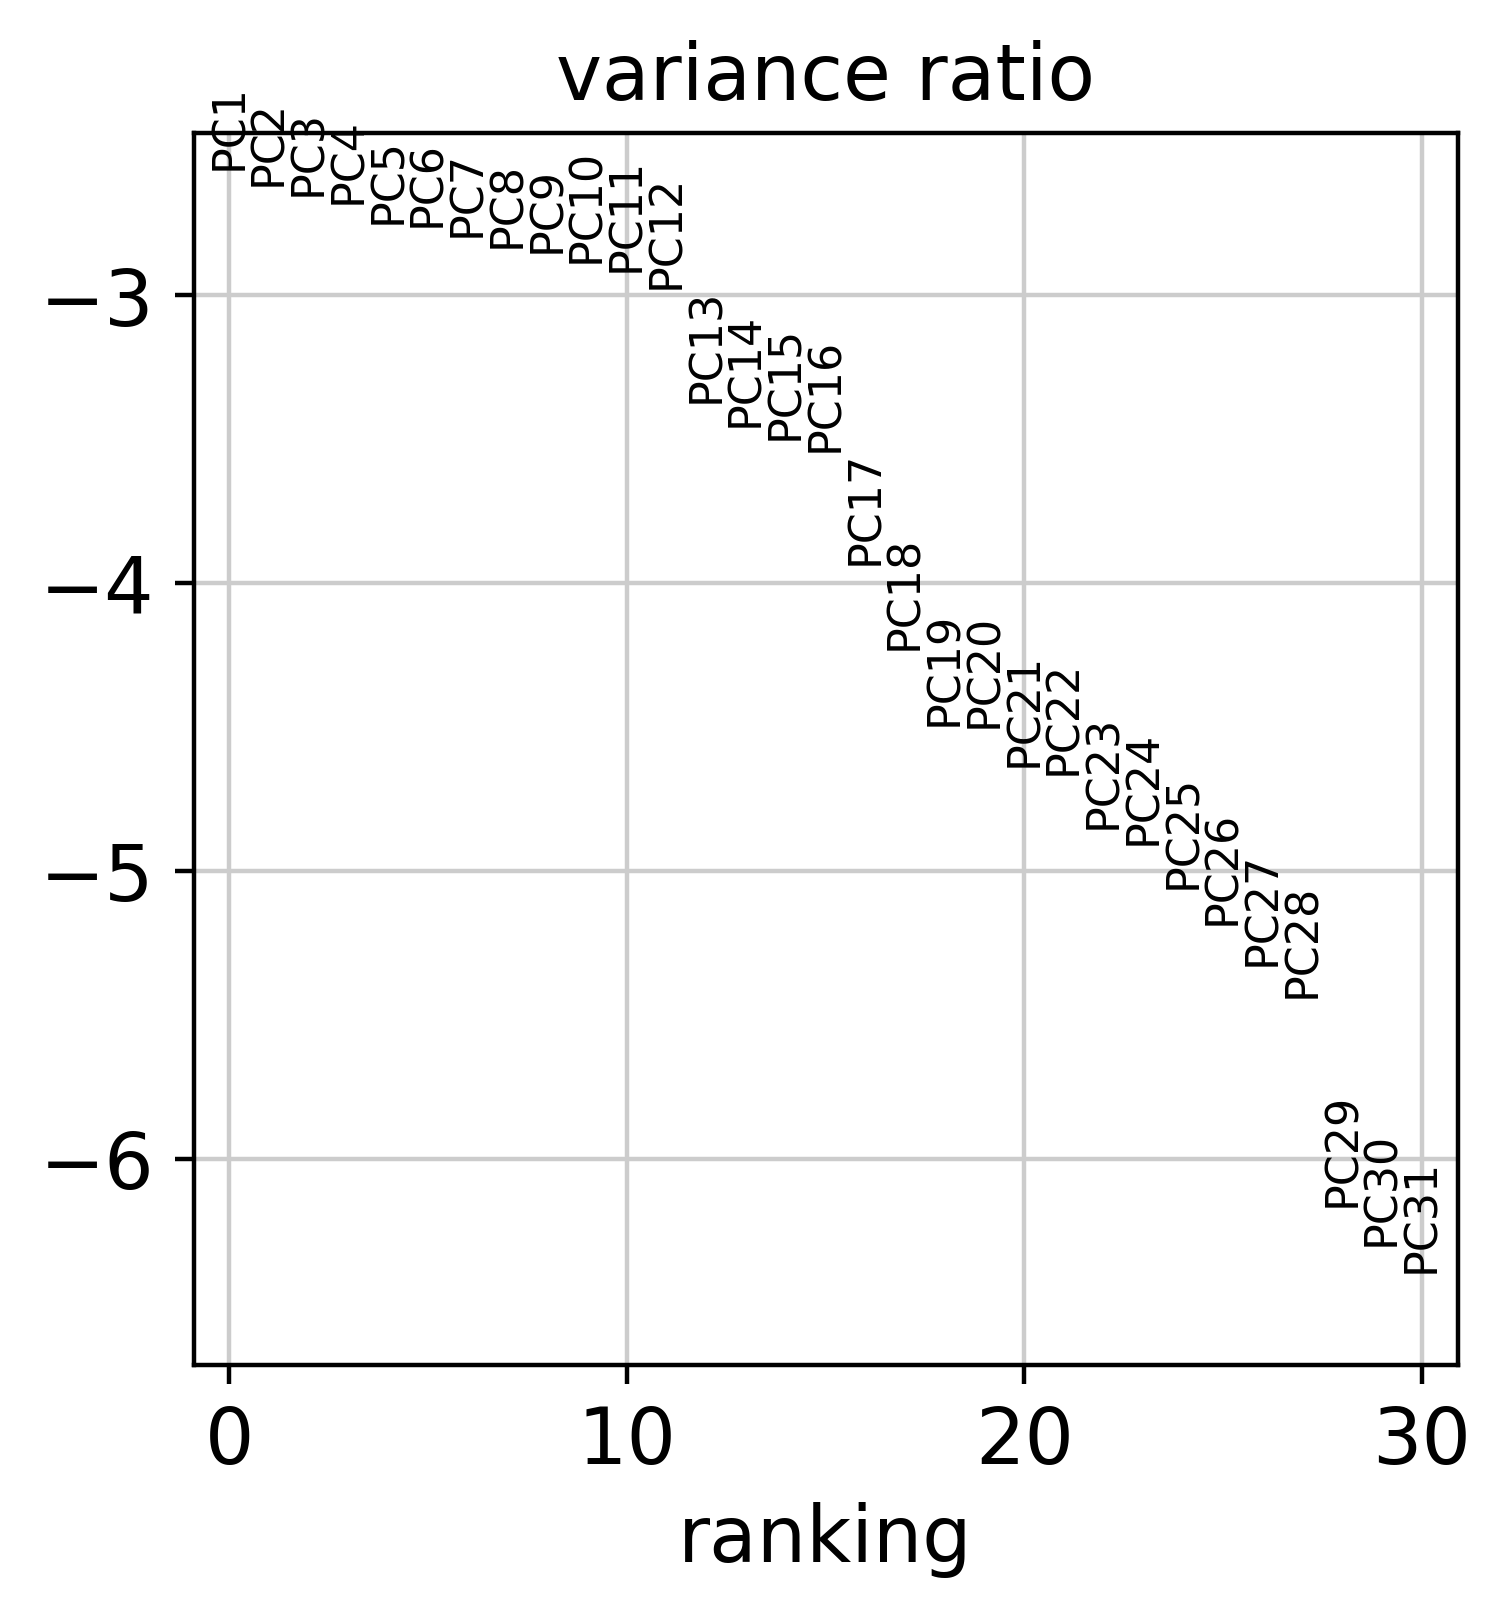

In [19]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
sc.pp.neighbors(adata)
sc.tl.umap(adata) #calculates the clusters

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


<Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>

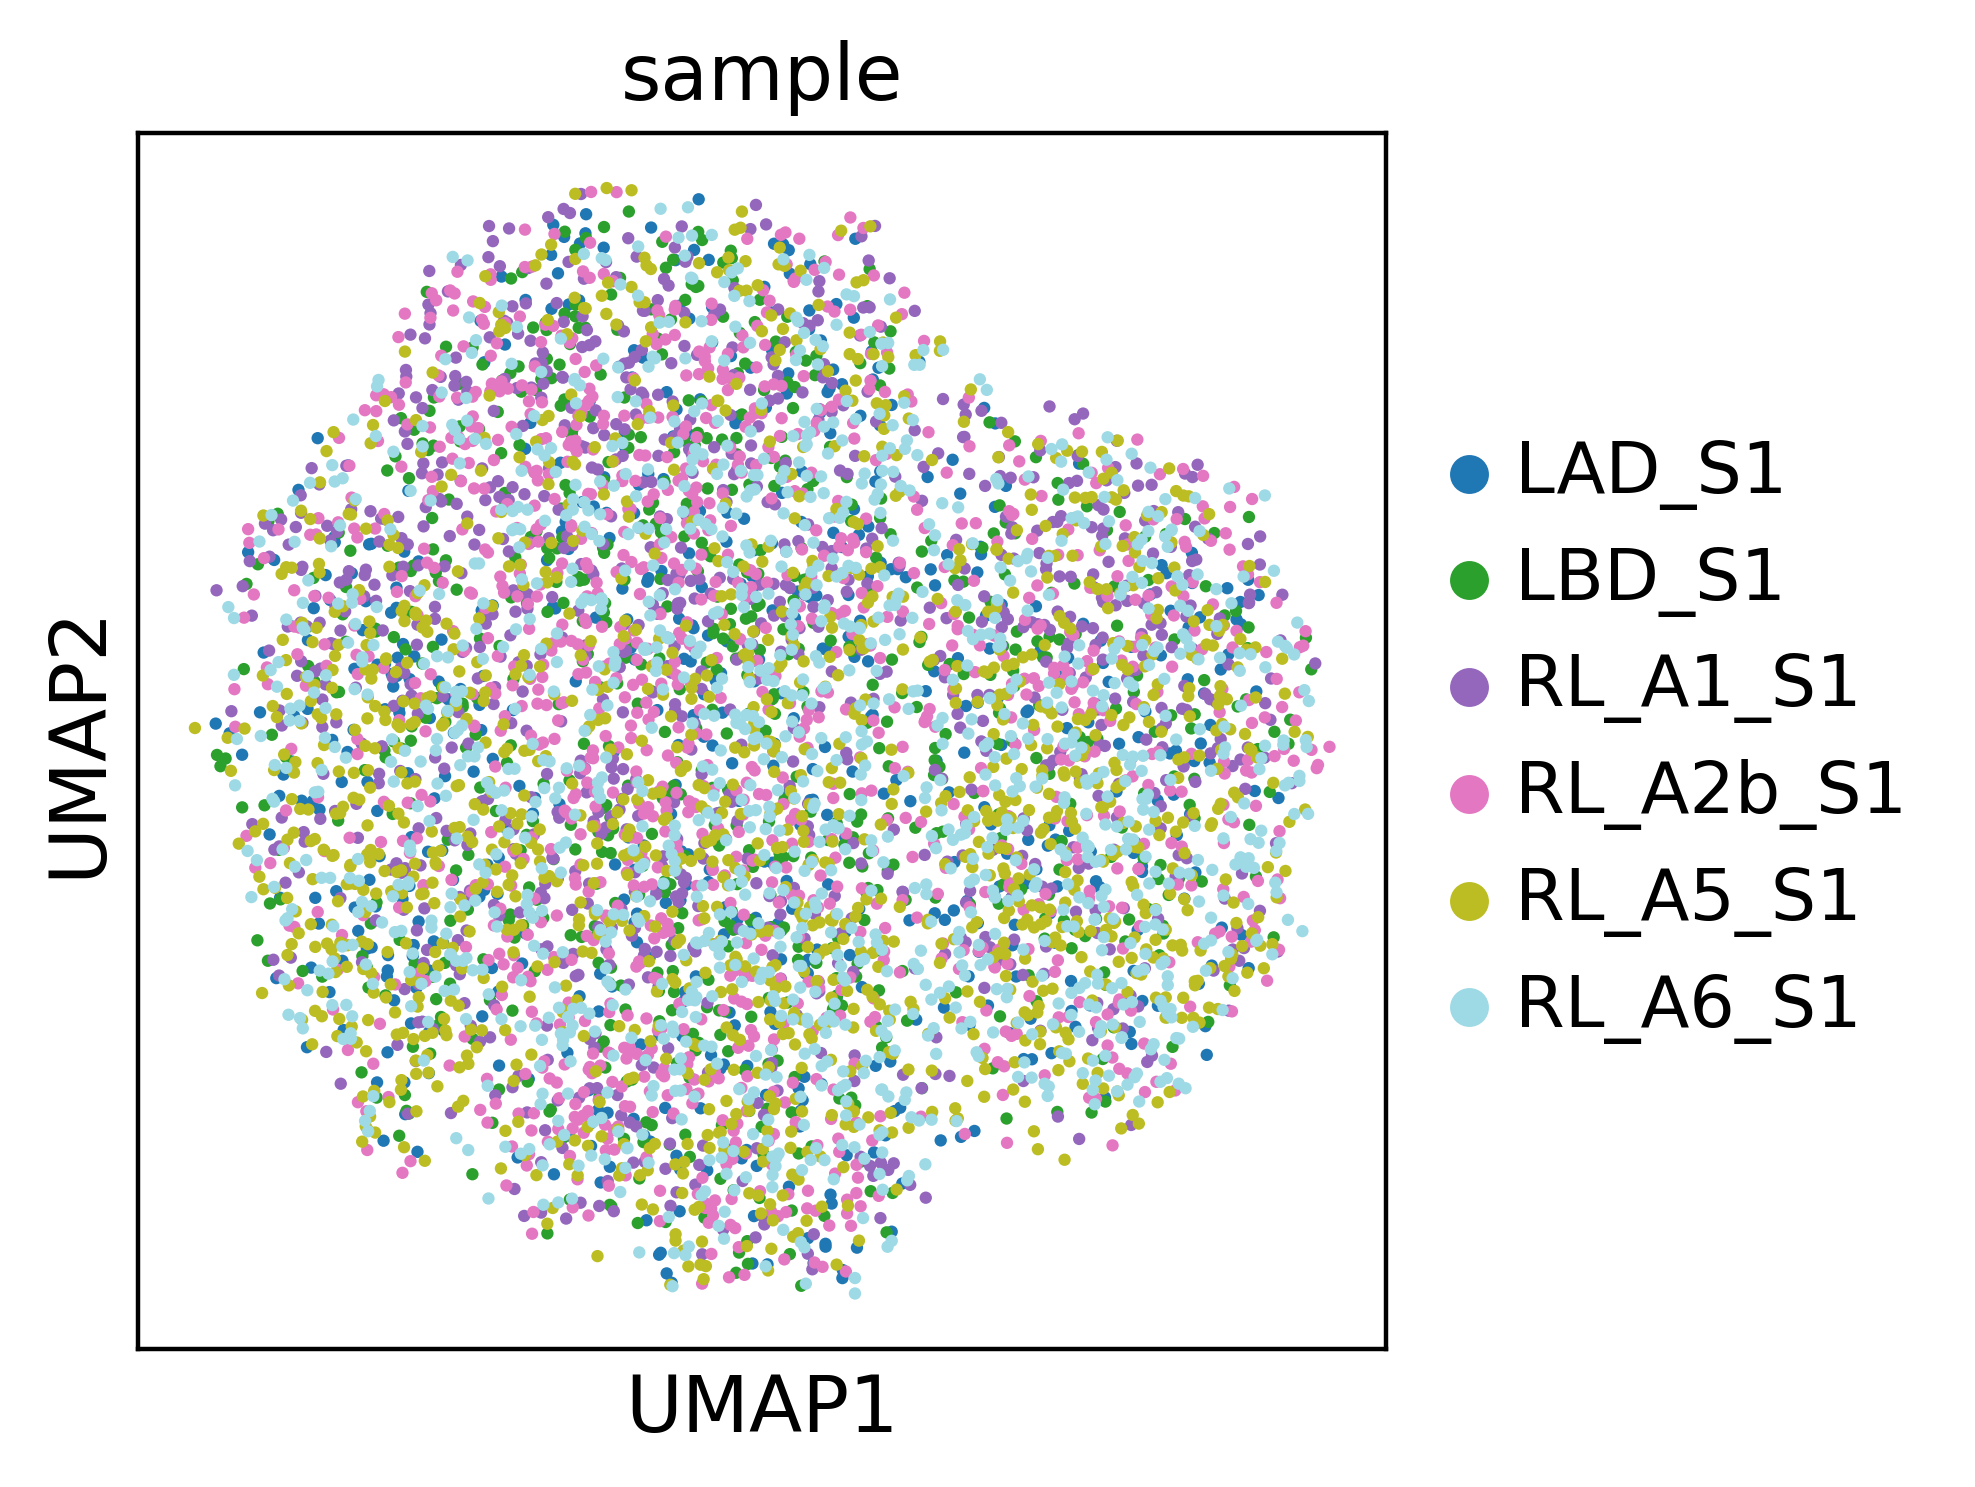

In [21]:
sc.pl.umap(adata, color=['sample']) #plots the clusters

running Leiden clustering


/tmp/ipykernel_541102/3334473871.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.50)


    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

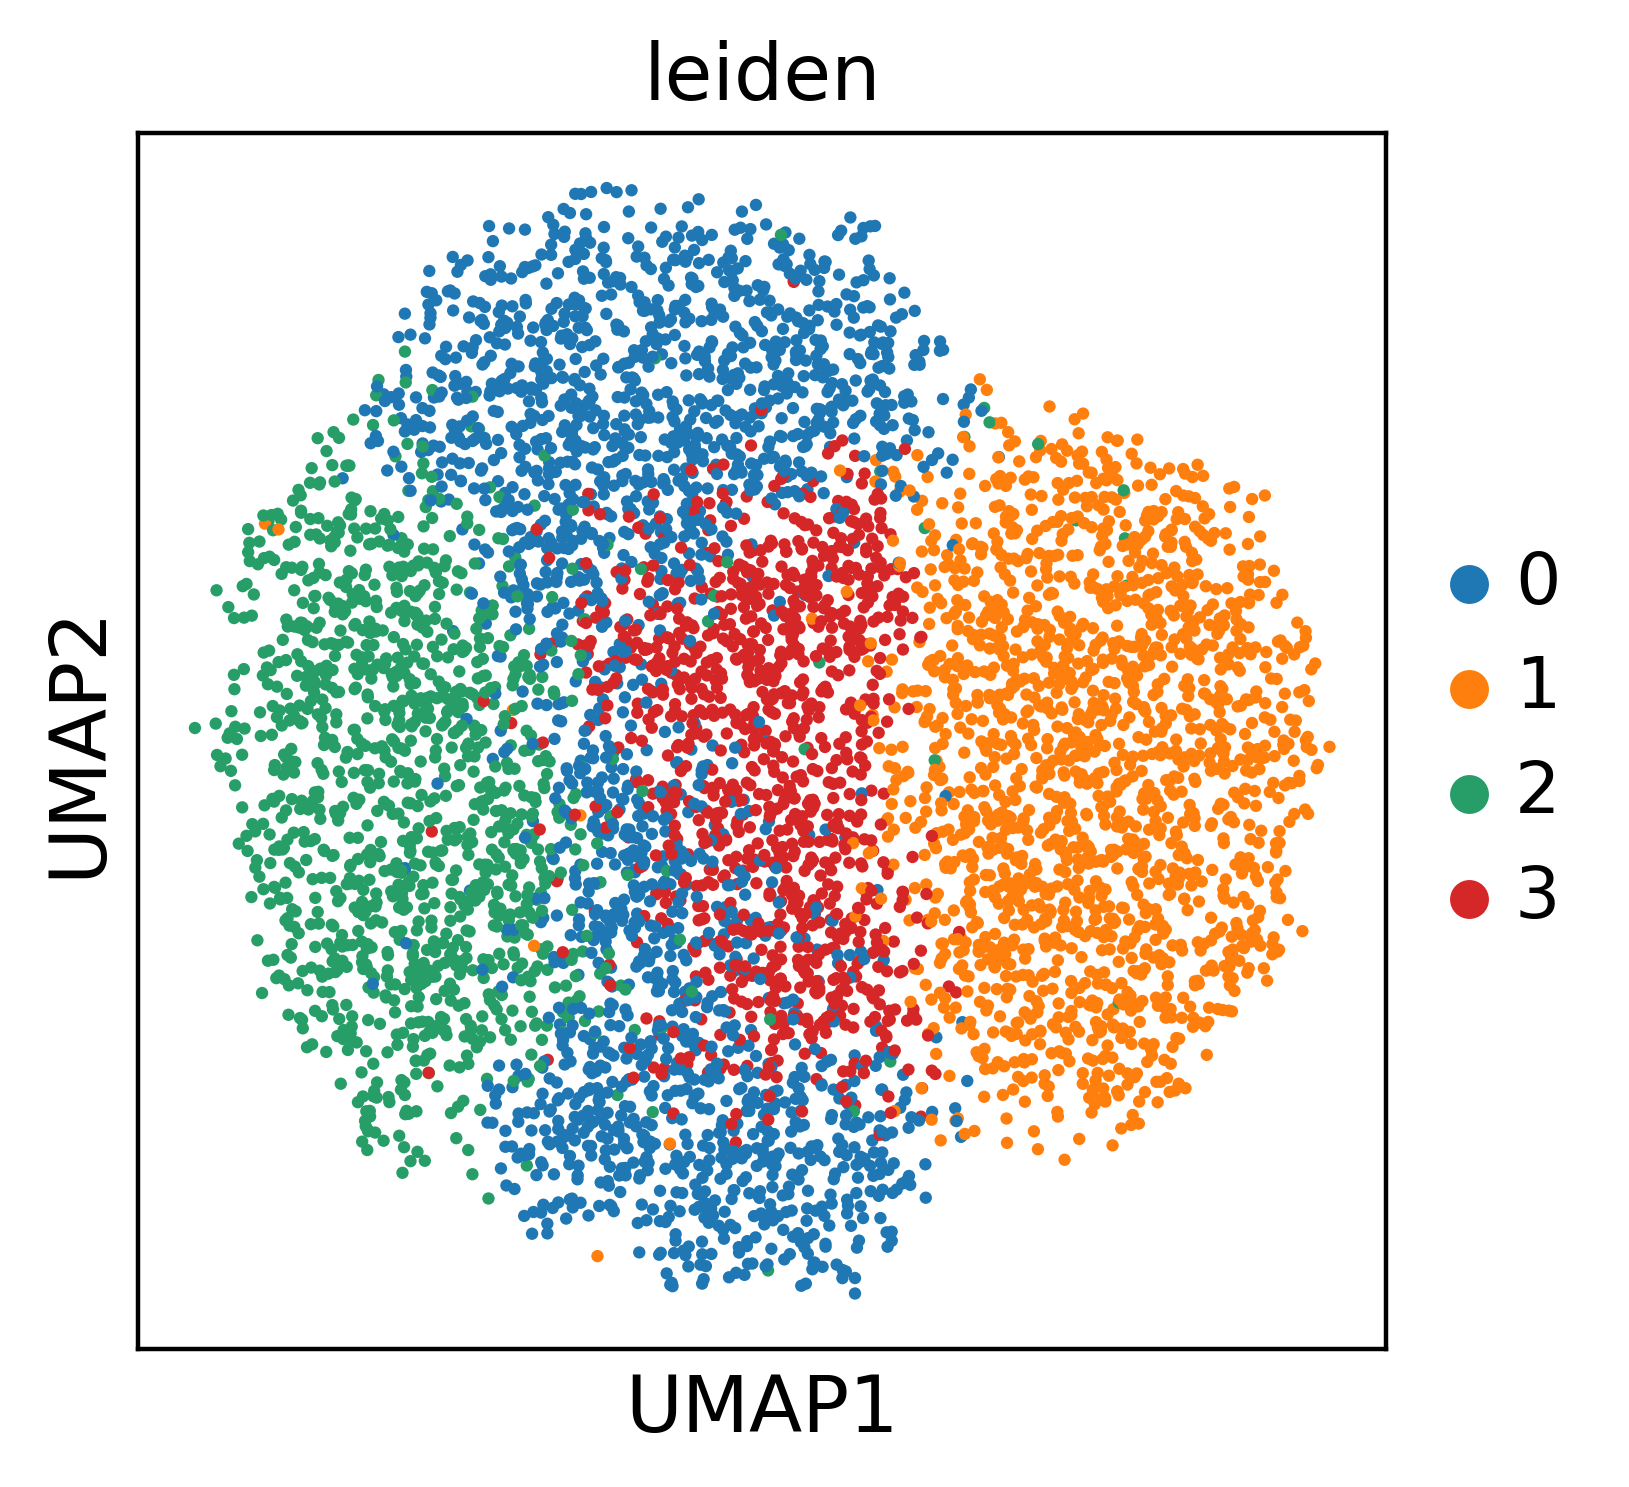

In [22]:
sc.tl.leiden(adata, resolution=0.50)
sc.pl.umap(adata, color=['leiden'])
#makes sense to use a smaller resolution since these all seem to be the same cell type (based on above PCA coordinates)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


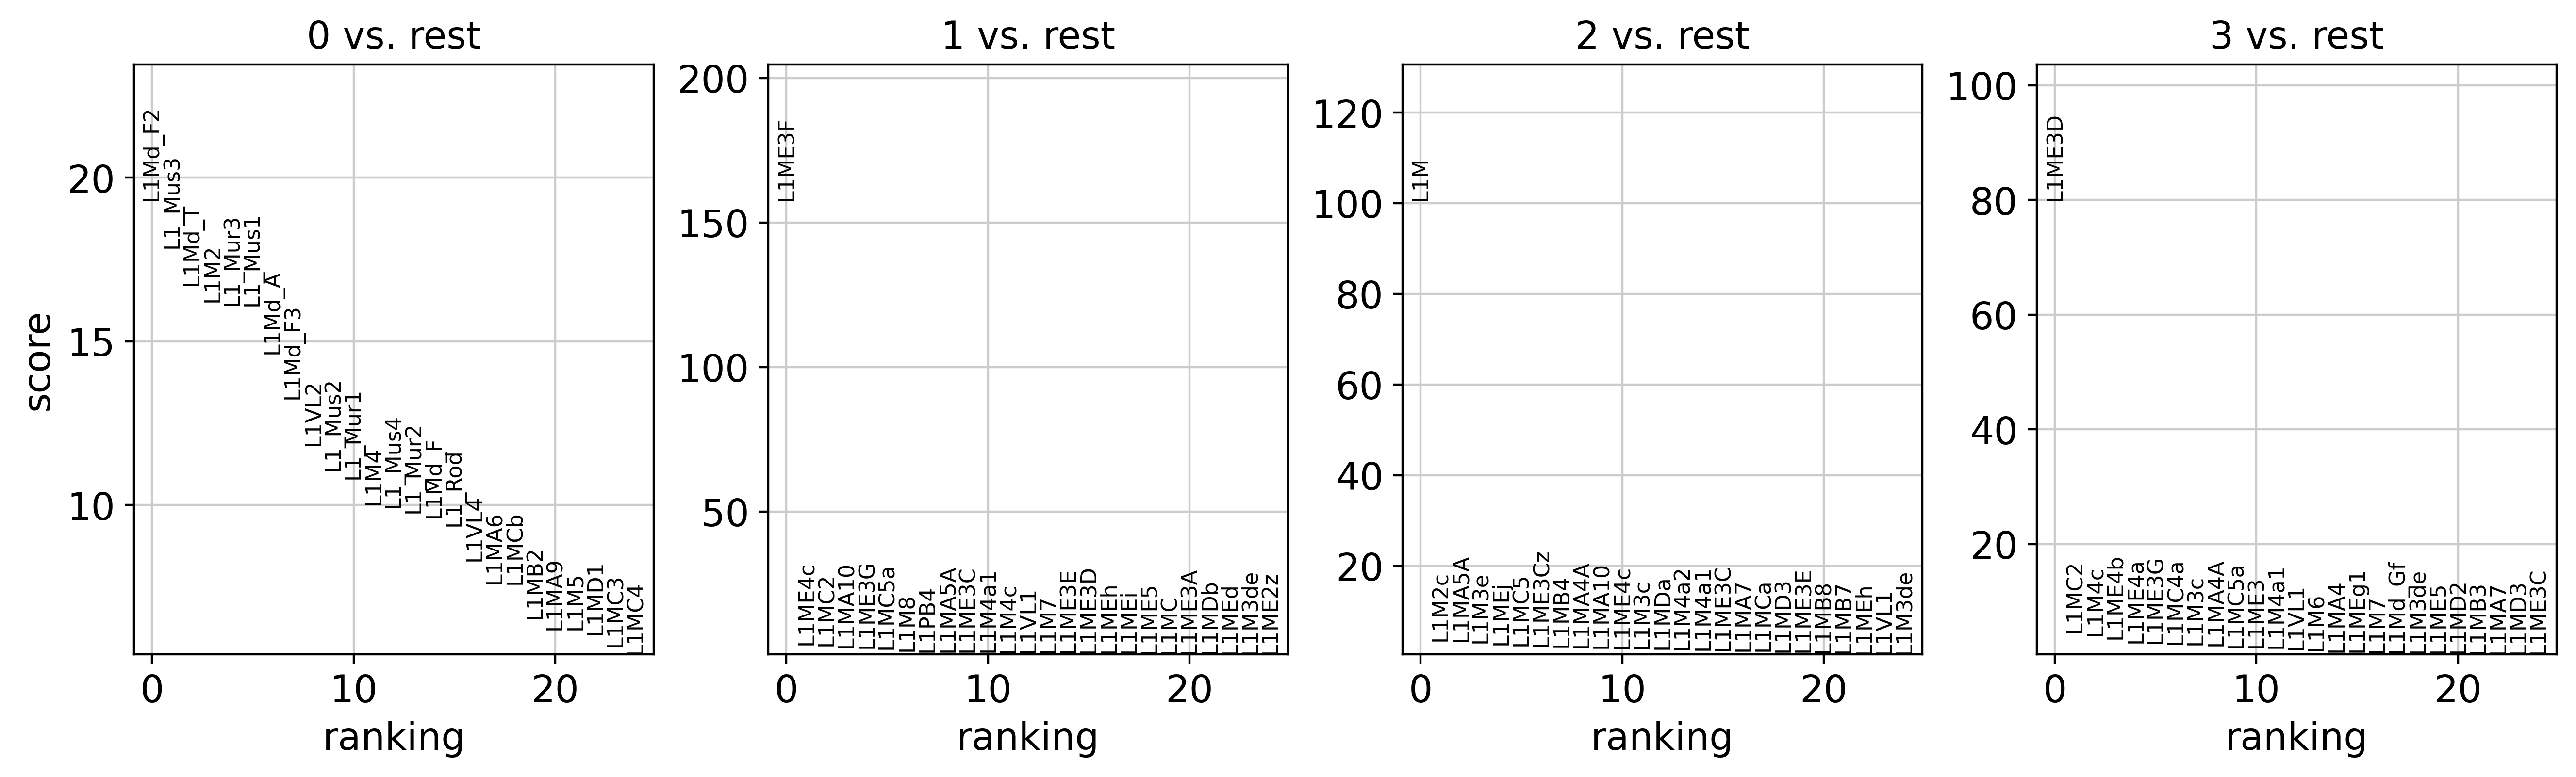

In [23]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

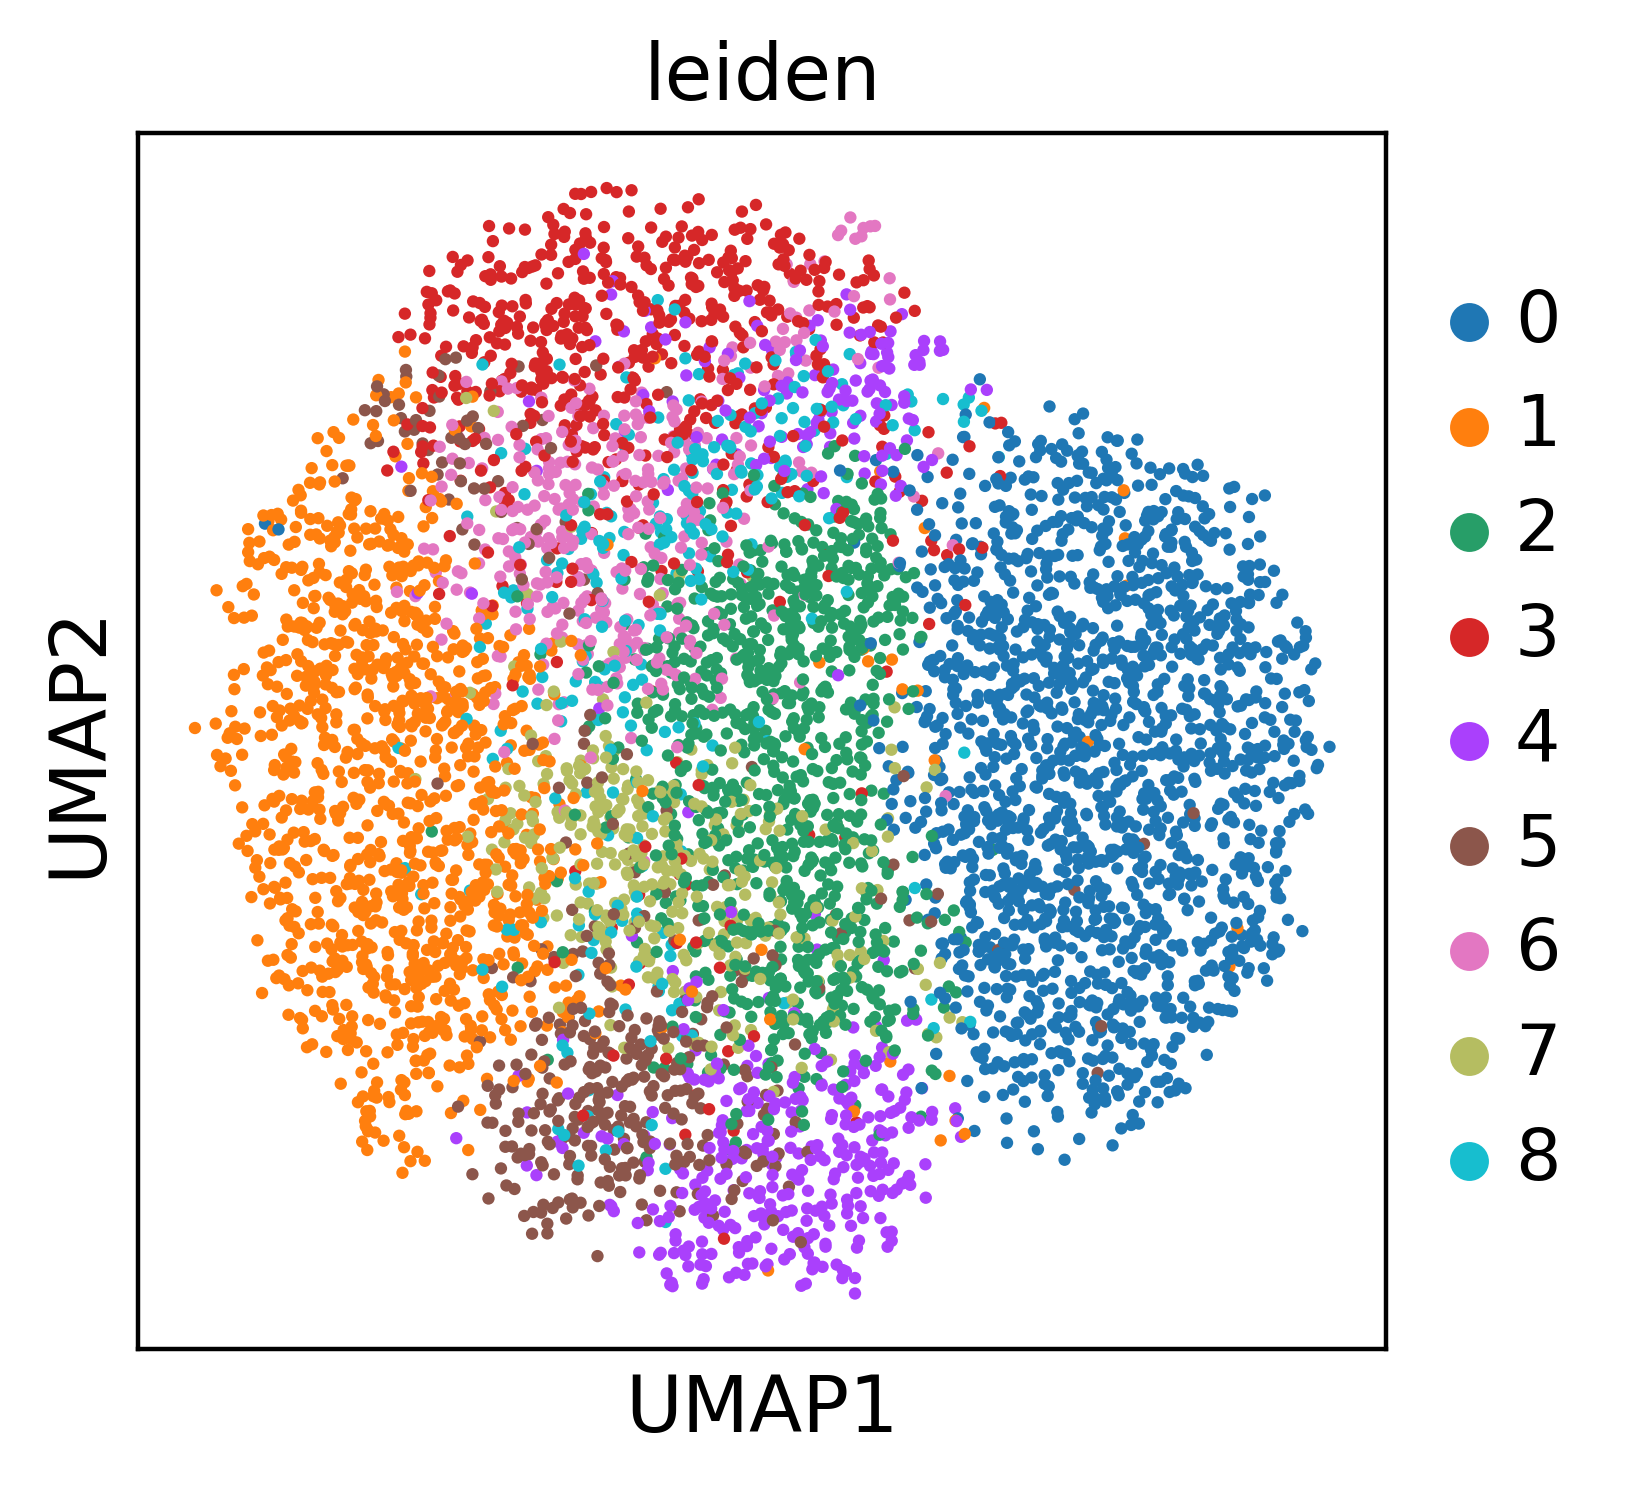

In [24]:
sc.tl.leiden(adata, resolution=0.75)
sc.pl.umap(adata, color=['leiden'])

# Find Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


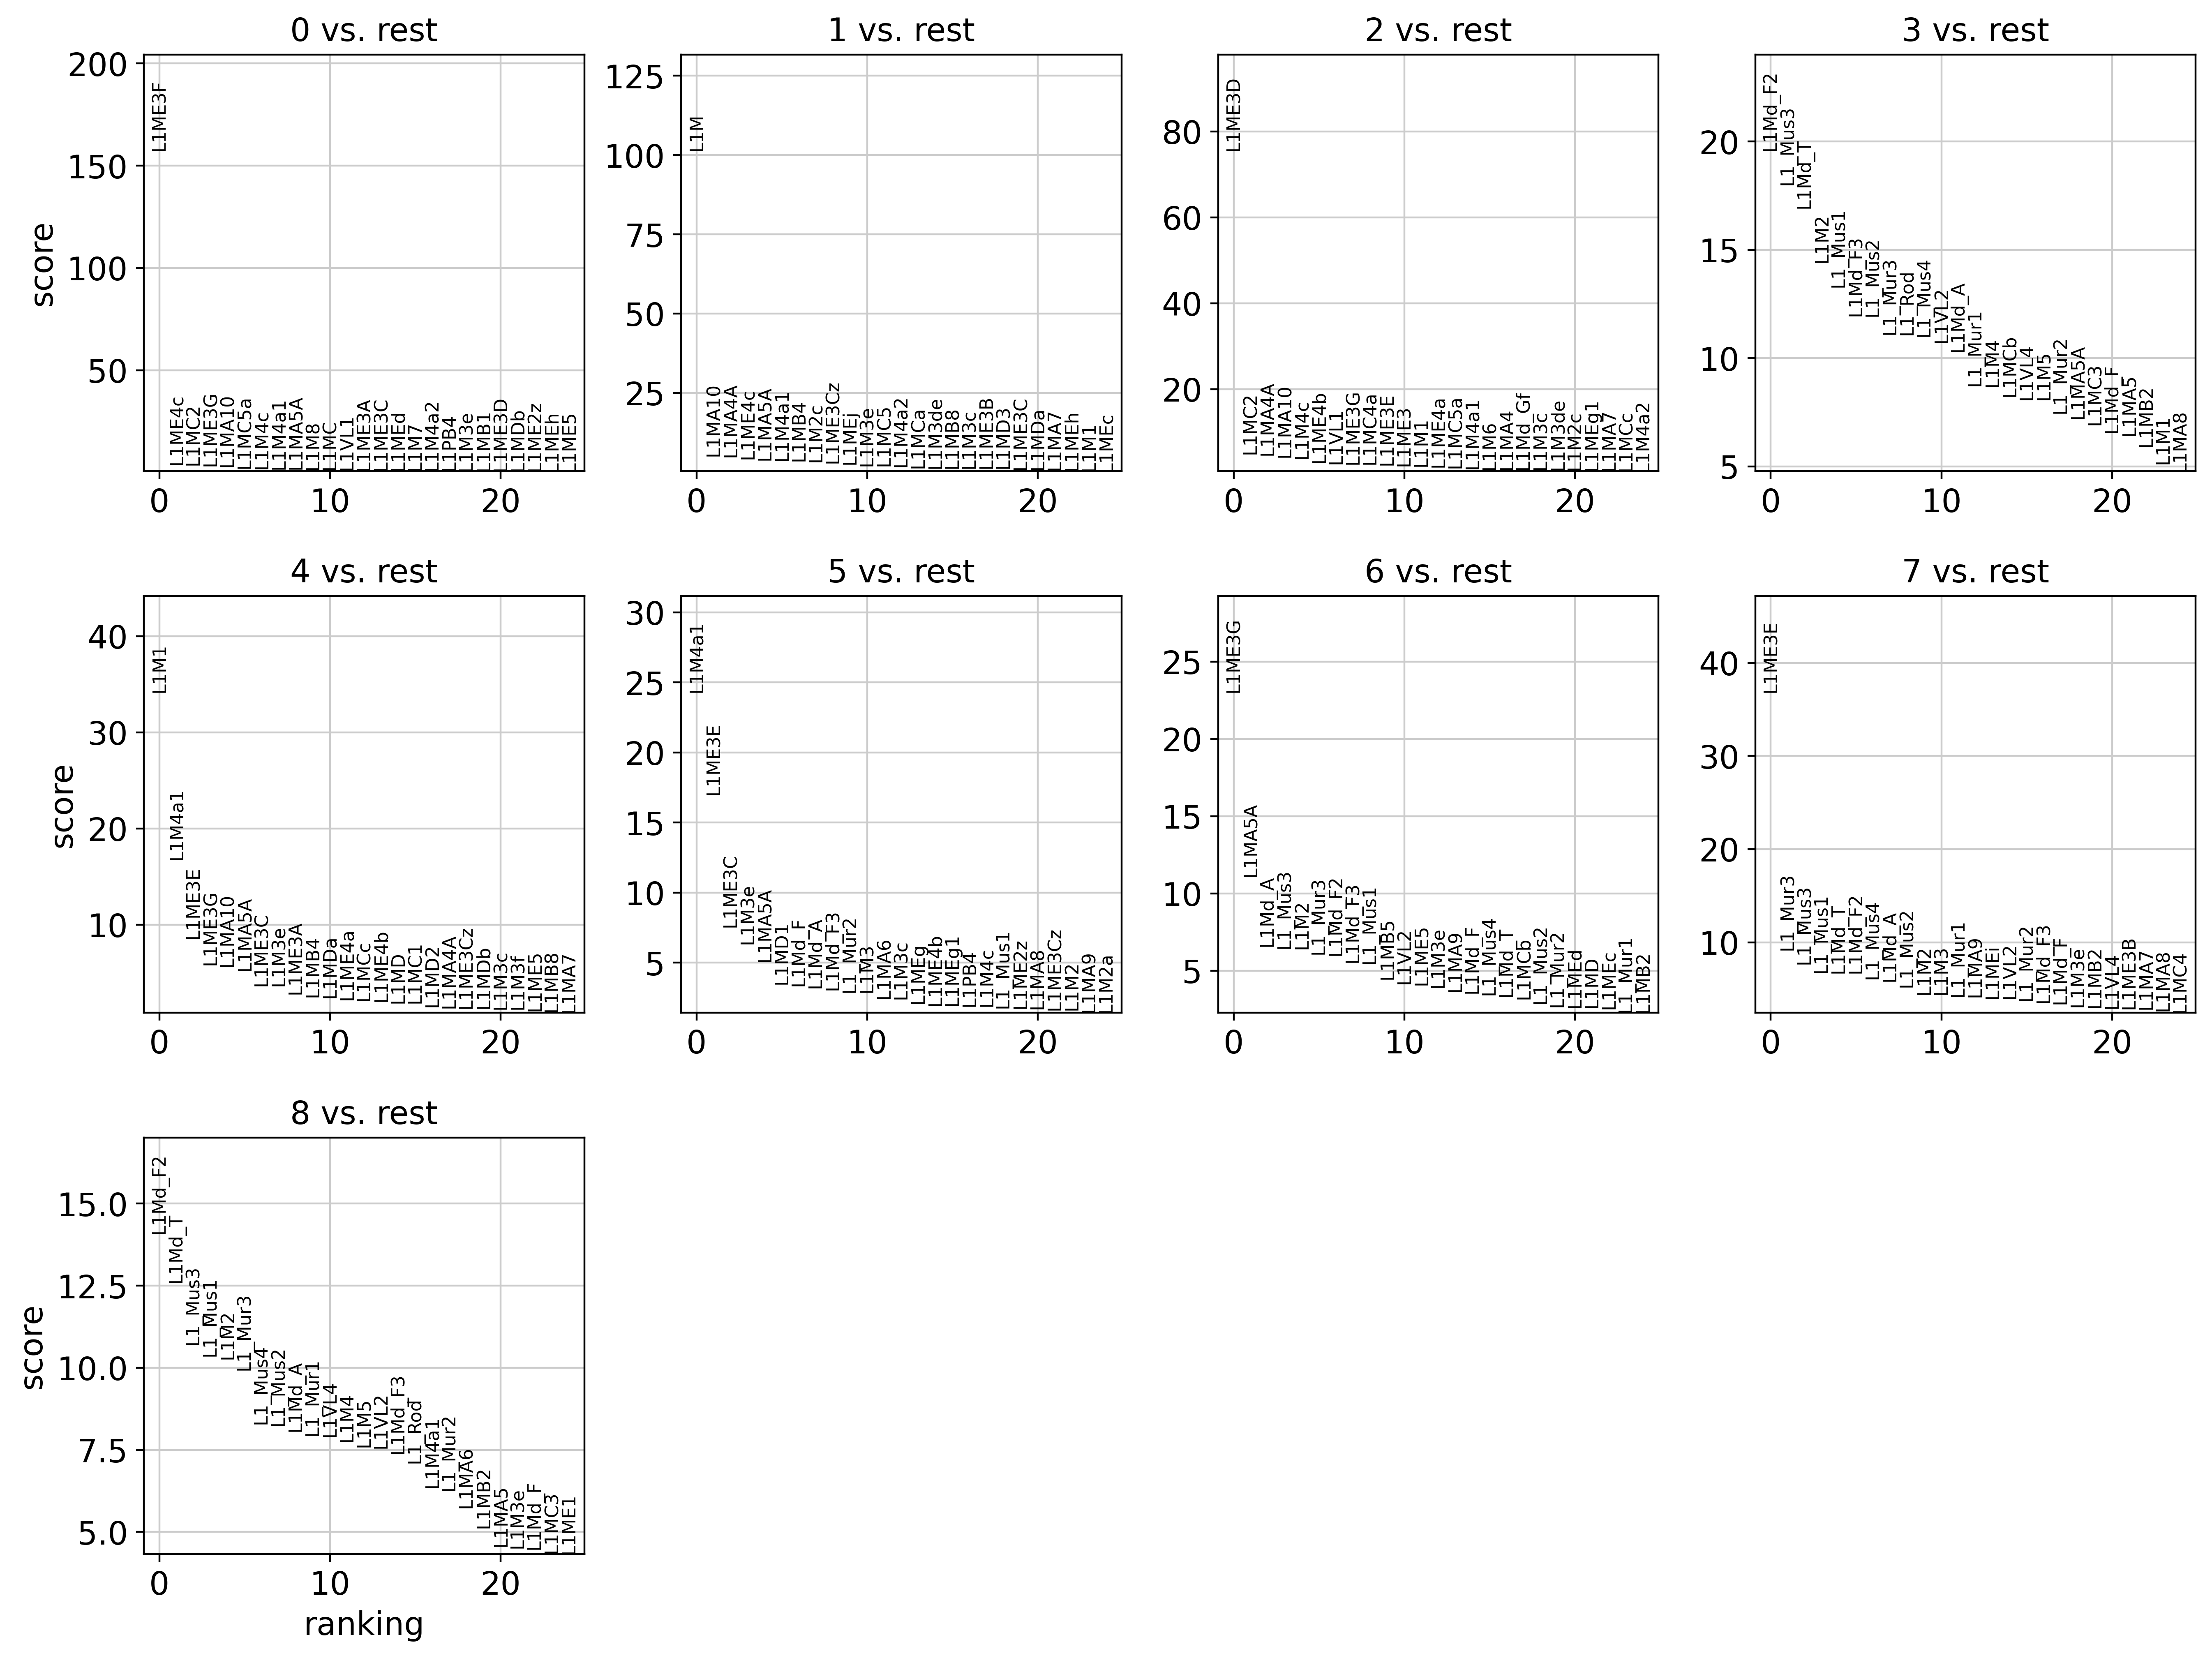

In [25]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
#cluster 1 seems to only express the L1ME3F gene